# Introduction
This is the project report for the final course project.

**Team 97:** Cody Talmadge(codytt2@illinois.edu), Seth Joslin (sjoslin2@illnois.edu), and Sree Alaparthi (sa68@illinois.edu)

**Github:** [https://github.com/sjoslin2/Spring-24-DLH](https://github.com/sjoslin2/Spring-24-DLH)

**Video:** [Link to the google drive](https://drive.google.com/file/d/1-44eZ1X_3JA6lhmW0lIfsQZrf1oo_NGo/view)

**Paper 33 - ScoEHR:** Generating Synthetic Electronic Health Records using Continuous-time Diffusion Models[1] https://www.mlforhc.org/s/ID145_Research-Paper_2023.pdf

*   **Background of the problem**

    Patient health data, mainly kept in electronic health records (EHRs), plays a crucial role in the healthcare sector, with its increase in usage rates in hospitals across both the US and UK. EHRs include both structured and unstructured data, from patient demographics to medical images, enabling extensive analysis to unveil disease progression and health trends. Leveraging EHRs, predictive and prescriptive machine learning models have revolutionized patient care, predicting outcomes and disease severity with high accuracy. However, sharing EHRs remains constrained by regulatory frameworks like HIPAA and GDPR, compounded by challenges in aggregating EHRs due to varying standards and policies. Synthetic data generation offers a solution, addressing access and bias issues. However, generating synthetic EHRs is complex due to high dimensionality and data heterogeneity. While  generative Adversarial Networks (GANs) have been popular, they face challenges like mode collapse and unstable training. Recently, diffusion models have emerged as promising alternatives, offering stable training and high-fidelity data synthesis, making them ideal for synthetic EHR generation.


*   **Paper explanation**

    This paper introduces ScoEHR, a synthetic EHR generation framework employing continuous-time diffusion models. ScoEHR combines an autoencoder with a continuous-time diffusion model.The ScoEHR transforms real data into a low-dimensional space through an encoder from a pre-trained autoencoder. Within this low-dimensional space, a forward stochastic differential equation (SDE) diffuses the data. Subsequently, a reverse SDE is learned and applied to generate new synthetic data. This synthetic data is then transformed using the decoder from the autoencoder to produce the final synthetic EHR data.
    ScoEHR was compared to medGAN, medWGAN, and medBGAN using the following four performance metrics of data generation utility:
     
    *   Preservation of feature marginal relationships,
    *   Preservation of feature correlations,
    *   Preservation of full feature distribution using log-clusters,
    *   Synthetic data performance in downstream predictions of patient outcomes.

    Additionally, Physician evaluation confirms its realism, establishing ScoEHR as the current state-of-the-art in synthetic EHR generation.

# Scope of Reproducibility
There are two central hypotheses that were tested as a part of this paper: ScoEHR produces higher-quality synthetic data than the previously-leading synthetic EHR models and United States board-certified physicians cannot differentiate between the synthetic data produced by ScoEHR and real EHR data.


1.   **Hypothesis 1:**
 - **Hypothesis:** The first hypothesis was tested by comparing ScoEHR against the three-leading synthetic EHR models (medGAN[2], medWGAN[3], and medBGAN[3]) on four key areas: preservation of feature marginal relationships, preservation of feature correlations, preservation of full feature distributing using log-clusters, and synthetic data performance in downstream predictions of patient outcomes.
 - **Scope of Reproducibility:** While we were not successful at fully replicating the aforementioned hypothesis using the MIMIC-III dataset, our results were better than two of the three leading synthetic EHR models (medGAN[2] and medBGAN[3]) and our outcomes were similar to the results provided in the paper (though they weren't as good on some key metrics, they were within the right order of magnitude). The results are discussed in detail in the results and discussion section of this report.

2.   **Hypothesis 2:**
 - **Hypothesis:** The second hypothesis was tested by presenting both synthetic and real EHR data to physicians and asking them to identify the “real” data. By looking at what portion of synthetic data they identified as “real” and comparing it with the portion of real data they identified as “real” the authors were able to determine that physicians were not able to tell the difference between the synthetic and real data.
 - **Scope of Reproducibility:** This was infeasible without real doctors available to validate the authenticity of synthetic records.

# Methodology

The Methodology section consists of 5 sub-sections:
- Environment
- Data
- Model
- Training
- Evaluation

For each sub-section, a description/explanation of that sub-section is given as well as implementation code.

## Environment
### Python Version

Python 3.10.12

In [ ]:
!python --version

Python 3.10.12


### Manual Setup Needed
In order to run this notebook, you will need to:
1. Ensure that you downloaded it from the [github repository](https://github.com/sjoslin2/Spring-24-DLH).  This means that you should see the following folders:
- `./ablation_saved_models/` - This is where the saved Score Net models for the learning rate/epoch ablations live.
- `./ablation_synthetic_data/` - This is where the synthetic data generated by the ablation models live.
- `./additional_workbooks/` - contains the additional notebooks that contains the data preprocessing and loading synthetic data using pyHealth.
- `./mimic/` - Folder where you need to manually add the MIMIC-III data files (detailed instructions in Data sub-section).
- `./saved_models/` - This is where the saved Autoencoder and Score Net model parametres live.
- `./stats/` - This contains stats information around the model training.  If you train these models from scratch then your model trainings stats are displayed instead.
- `./synthetic_data/` - This contains synthetic data generated by the model.  If you want to generate your own synthetic data you'll need ~30 minutes of GPU time.
2. Ensure you have added the MIMIC-III data files into the `./mimic/` folder (detailed instructions in the Data sub-section).

**Running This Notebook on Colab**

If you would like to run this notebook in Colab, place it and all of the files from the github repository into a "ScoEHR" folder in your Google Drive.

**Running This Notebook Without Colab**

Make sure this notebook is in the same folder as all of the other files from the github repository.

### Dependencies and Packages
This section installs all required modules and imports them for later use.
If you are running this notebook in Colab , please install torchsde.
Otherwise, please install all the required packages using requirements.txt using the command below.
pip3 install -r requirements.txt

In [ ]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 737.9 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Import all the required packages
import torch
import os
import tqdm
import math
import time
import torchsde
import gc
import sklearn.cluster

import numpy as np
import torch.nn.functional as F
import _pickle as pickle
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader
from torch.nn.init import _calculate_fan_in_and_fan_out
from torch.optim import lr_scheduler
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from datetime import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt


In [ ]:
# Mount the google drive.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

device = "cuda" if torch.cuda.is_available() else "cpu"

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  file_location = "/content/drive/MyDrive/ScoEHR/"
else:
  file_location = "."

Mounted at /content/drive


##  Data
### Data Download Instructions
We are using MIMIC-III dataset from physionet -> https://physionet.org/content/mimiciii/1.4/.

Please follow the instructions in piazza post #338 to access the MIMIC-III dataset. Download and decompress the following two csv files and place them in the `./mimic` folder:
- `ADMISSIONS.csv`
- `DIAGNOSES_ICD.csv`

### Data Descriptions

MIMIC-III critical care database is an freely accessible database containing de-identified health data associated with approximately 40,000 patients who stayed in intensive care units at the Beth Israel Deaconess Medical Center between 2001 and 2012.There has been several versions of the MIMIC-III database since it was released.Current version of the dataset is MIMIC-III v1.4 released on 2nd September 2016 which majorly focused on enhancement of data quality and providing addition of large amount of data.

MIMIC-III is a relational database consisting of 26 tables, out of which only 2 tables namely ADMISSIONS and DIAGNOSES_ICD are used for this project. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient and HADM_ID refers to a unique admission to the hospital.

The **ADMISSIONS** table contains several columns, including *row_id, subject_id, hadm_id, admittime, dischtime, deathtime, admission_type, admission_location, discharge_location, insurance, language, religion, marital_status, ethnicity, edregtime, edouttime, diagnosis, hospital_expire_flag, and has_chartevents_data*. However, for this project, we focus on only three columns: ***subject_id, hadm_id, and admittime***. The hadm_id , which  identifies the hospital stay serves as the primary key and the subject_id is the foriegn key for the ADMISSIONS table.A patient with multiple admissions will have duplicate subject_id entries for the same hadm_id. The admittime column represents the time of admission to the hospital.


The **DIAGNOSES_ICD** consists of following columns:
*row_id,	subject_id,	hadm_id, seq_num,	icd9_code*.
For this project, we are only utilizing two columns: ***hadm_id ***and*** icd9_code***. The icd9_code colum provides the diagnoses code.

Statistics of MIMIC-III dataset:
*   Dataset: MIMIC3Dataset
*   Number of patients: 49993
*   Number of visits: 52769
*   Number of visits per patient: 1.0555
*   Number of events per visit in DIAGNOSES_ICD: 9.1038



### Data Preprocessing
For the MIMIC-III dataset, we follow the data preprocessing methodology outlined by Choi et al. (2017). The code below processes the MIMIC-III dataset, creating longitudinal diagnosis records for patients and saves the serialized data to a file using pickle. It involves reading the ADMISSIONS.csv and DIAGNOSES_ICD.csv files, generalizing the ICD-9 codes up to the first three digit codes, and then generating the longitudinal diagnosis patient records. The resulting matrix file comprises one row per patient and one column per ICD code (later treated as features). Each row represents the count of occurrences of the corresponding patient's EHR containing the ICD code in their visits. If the patient's EHR never includes the ICD code across any visits, a '0' is placed in the column.

Set `generate_matrix_file = True` (default) to generate the preprocessed `.matrix` file required for training the model and/or comparing the real and synthetic data).

In [ ]:
# Modified from: https://github.com/mp2893/medgan/blob/master/process_mimic.py

admissionFile = os.path.join(file_location, 'mimic/ADMISSIONS.csv')
diagnosisFile = os.path.join(file_location, 'mimic/DIAGNOSES_ICD.csv')
outFile = os.path.join(file_location, 'mimic/mimic_processed_choi_count.matrix')

generate_matrix_file = True

def convert_to_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4: return dxStr[:4] + '.' + dxStr[4:]
        else: return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3] + '.' + dxStr[3:]
        else: return dxStr

def convert_to_3digit_icd9(dxStr):
    if dxStr.startswith('E'):
        if len(dxStr) > 4: return dxStr[:4]
        else: return dxStr
    else:
        if len(dxStr) > 3: return dxStr[:3]
        else: return dxStr

if generate_matrix_file:
    binary_count = 'count'

    print('Building pid-admission mapping, admission-date mapping')
    pidAdmMap = {}
    admDateMap = {}
    infd = open(admissionFile, 'r')
    infd.readline()
    for line in infd:
        tokens = line.strip().split(',')
        pid = int(tokens[1])
        admId = int(tokens[2])
        admTime = datetime.strptime(tokens[3], '%Y-%m-%d %H:%M:%S')
        admDateMap[admId] = admTime
        if pid in pidAdmMap: pidAdmMap[pid].append(admId)
        else: pidAdmMap[pid] = [admId]
    infd.close()

    print('Building admission-dxList mapping')
    admDxMap = {}
    infd = open(diagnosisFile, 'r')
    infd.readline()
    for line in infd:
        tokens = line.strip().split(',')
        admId = int(tokens[2])
        # Uncomment this line and comment the line below, if you want to use the entire ICD9 digits.
        # dxStr = 'D_' + convert_to_icd9(tokens[4][1:-1])
        dxStr = 'D_' + convert_to_3digit_icd9(tokens[4][1:-1])
        if admId in admDxMap: admDxMap[admId].append(dxStr)
        else: admDxMap[admId] = [dxStr]
    infd.close()

    print('Building pid-sortedVisits mapping')
    pidSeqMap = {}
    for pid, admIdList in pidAdmMap.items():
        #if len(admIdList) < 2: continue
        sortedList = sorted([(admDateMap[admId], admDxMap[admId]) for admId in admIdList])
        pidSeqMap[pid] = sortedList

    print('Building pids, dates, strSeqs')
    pids = []
    dates = []
    seqs = []
    for pid, visits in pidSeqMap.items():
        pids.append(pid)
        seq = []
        date = []
        for visit in visits:
            date.append(visit[0])
            seq.append(visit[1])
        dates.append(date)
        seqs.append(seq)

    print('Converting strSeqs to intSeqs, and making types')
    types = {}
    newSeqs = []
    for patient in seqs:
        newPatient = []
        for visit in patient:
            newVisit = []
            for code in visit:
                if code in types:
                    newVisit.append(types[code])
                else:
                    types[code] = len(types)
                    newVisit.append(types[code])
            newPatient.append(newVisit)
        newSeqs.append(newPatient)

    print('Constructing the matrix')
    numPatients = len(newSeqs)
    numCodes = len(types)
    matrix = np.zeros((numPatients, numCodes)).astype('float32')
    for i, patient in enumerate(newSeqs):
        for visit in patient:
            for code in visit:
                if binary_count == 'binary':
                    matrix[i][code] = 1.
                else:
                    matrix[i][code] += 1.

    pickle.dump(matrix, open(outFile, 'wb'), -1)
    print('Matrix construction complete')

Building pid-admission mapping, admission-date mapping
Building admission-dxList mapping
Building pid-sortedVisits mapping
Building pids, dates, strSeqs
Converting strSeqs to intSeqs, and making types
Constructing the matrix
Matrix construction complete


### Define DataLoader Class
Used to create Datasets and Dataloaders to pull data from the generated `.matrix` file

In [ ]:
# Modified from https://github.com/aanaseer/ScoEHR/blob/main/scoehr/datasets.py

class Dataset():
    def __init__(self, data_dir, data_file):
        pass

    def data(self, use_train_test_split=True, test_size=0.30):
        if use_train_test_split:
            train_data, test_data = train_test_split(
                self.dataset_full, test_size=test_size, random_state=1
            )
            return train_data, test_data
        else:
            return self.dataset_full

class MIMIC3_ICD(Dataset):
    def __init__(
        self, data_file="mimic/mimic_processed_choi_count.matrix"
    ):
        """Loads the MIMIC-III dataset from the data directory."""
        data_path = os.path.join(file_location, data_file)
        data = np.load(data_path, allow_pickle=True)
        self.dataset_full = torch.from_numpy(data)

### Load the Data
Load the `.matrix` file and generated train and test dataloaders.

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

load_data = True

batch_size = 64

if load_data:

    data_file = 'mimic/mimic_processed_choi_count.matrix'

    train_data, test_data = MIMIC3_ICD(data_file=data_file).data()

    real = test_data.detach()

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, drop_last=True)
    test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, drop_last=True)
    print("Train Data Shape: ", train_data.shape)
    print("Test Data Shape: ", test_data.shape)

Train Data Shape:  torch.Size([32564, 1071])
Test Data Shape:  torch.Size([13956, 1071])


## Model

### Citation to the original paper
Naseer, AA; Walker, B; Landon, C; Ambrosy, A; Fudim, M; Wysham, N; Toro, B; Swaminathan, S; Lyons, T. ScoEHR: Generating Synthetic Electronic Health Records using Continuous-time Diffusion Models. *Proceedings of Machine Learning Research*, Volume 219: 489–508, January 2023.[1]

**URL:** https://static1.squarespace.com/static/59d5ac1780bd5ef9c396eda6/t/64d1aa32ed57852af9c0ad60/1691462195379/ID145_Research+Paper_2023.pdf

### Link to the original paper's repo
https://github.com/aanaseer/ScoEHR/tree/main/scoehr

### Model Description
The synthetic generation process involves two different models:
- Autoencoder: Used to lower the dimensionality of the data
- Continuous-Time Diffusion Model: Used to generated synthetic data

The Autoencoder is used to lower the dimensionality from the original dataset (one feature per ICD code or 1,071 features) to 144 features.  This helps to capture relationships between related ICD codes and reduces the dimensionality of the output data that the continuous-time diffusion model must generate.

The Autoencoder is first trained and tested by itself to ensure that the Autoencoder model is able to successfully reduce the dimensionality of the data and then reproduce that original data using the reduced dimensionality dataset.  Then, the training data is encoded using the autoencoder and the encoded training data is used to train the Continuous-Time Diffusion model.  

This allows the Continous-Time Diffusion model to generate synthetic data in the lower dimensionality space.  The Continuous-Time Diffusion Model (aka UNet aka Score Net) is used to generate the synthetic data.  It works in combination with a Variance Preserving Stochastic Differential Equation (VPSDE).  The VPSDE function is designed to take real data and convert real data into random noise in a controlled manner.  The VPSDE function converts the data into noise at continuous time-steps between $0$ (completely real data) and $1$ (complete noise).  This synthetic data is then decoded using the trained Autoencoder to generate synthetic data in a feature space that is tied back to ICD codes.

#### Model Part 1 - Autoencoder

**Autoencoder Architecture:**

Layers | Configuration | Activation Function | Output Dimension (batch, feature)
--- | --- | --- | ---
fully connected | input size 1071, output size 144 | Tahnh | (512, 144)
fully connected | input size 144, output size 1071 | Sigmoid | (512, 1071)

**Autoencoder Training Objectives:**
- Loss Function: torch.nn.BCELoss with `reduction="sum"`
- Optimiser: torch.optim.Adam with `weight_decay=0.0001`

**Other Autoencoder Info:**
The model is not pretrained, but weights are initiatlized using `torch.nn.init.xavier_uniform_`.  The autoencoder post-encoding dimension of 144 was chosen by the original paper because previous papers indicated that 128 was the ideal post-encoding dimension, and 144 was the closest that worked with the UNet architecture of the upcoming Continous-Time Diffusion model.

#### Model Part 2 - UNet

**UNet Architecture:**
Due to the complex nature of the model, it's difficult to describe it in a single table that captures each layer and their size/type/activation function.  Instead, we focus on describing how the model works and it's overarching architecture.

Let's assume that this noise is added over $n$ timesteps.  The Score Net/UNet is trained to take data with noise added to it at time $t_k$ (where $k$ is between 1 and $n$), and back-convert that to the data at time $t_{k-1}$ (before the noise was added).  To support this, the loss function is defined as the difference between the actual $t_{k-1}$ and the predicted $t_{k-1}$.

Therefore we are training the model to be able to convert noisy data into real data.  Once this training is complete, to generate synthetic data we generate random noise and plug it into the model using a ReverseSDE function (that is designed to remove noise using the model).  We start with noise at $t_n$ and move step-wise backwards - at each step the model telling us what real parameters it _thinks_ could represent the next step with noise added.  When we get to $t_0$ we have data that follows the same patterns as real data, but because it was built based on noise is completely synthetic.

In terms of architecture, the Continuous-Time Diffusion Model (aka UNet aka Score Net) is a UNet architecture based on the reduced dimensionality space provided by the autoencoder.  It has two down-sampling layers that progressively reduce the size of the input data using convolution.  Each of these down-sampling layers also has two residual blocks that allow data to skip parts of the model as needed.  Each residual block also incorporates self-attention.  SiLU ($sigmoid(x) * x$) is used as the activation function throughout this model.

**UNet Training Objectives:**
- Loss Function: The loss function is a custom loss function designed to determine the loss between a predicted $t_{k-1}$ and an actual $t_{k-1}$.
- Optimiser: Adam with an adaptive learning rate.  The learning rate ($\lambda$) at epoch $t$ is defined by the exponential decay formula:

$$
\lambda(t) = \text{lr}_0 \cdot e^{-k \cdot t}
$$

where:
- $\text{lr}_0 = 0.5$ is the initial learning rate,
- $k = 0.1$ is the decay rate,
- $t$ is the epoch number.

**Other UNet Info:**
The model is not pretrained, but weights are initialized using `torch.nn.init.xavier_uniform_`.

### Implementation Code
Implementation code can be found in the following cells within this section.

### Pretrained Model
Available at https://github.com/sjoslin2/Spring-24-DLH/tree/main/saved_models.  Also used to generate synthetic data in the following cells (when enabled).

**Define Autoencoder Class**

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/models/autoencoder.py

class Autoencoder(nn.Module):
    def __init__(self, enc_in_dim, enc_out_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(nn.Linear(enc_in_dim, enc_out_dim),
                                     nn.Tanh())
        self.decoder = nn.Sequential(
                                     nn.Linear(enc_out_dim, enc_in_dim),
                                     nn.ReLU())

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Define weight initialization**

In [ ]:
def weights_init(m):
    # From https://github.com/astorfi/cor-gan/blob/b6df51a16399335bfe995c15b6951f053453fbb3/Generative/medGAN/MIMIC/pytorch/MLP/medGAN.py#L263 # noqa: E501
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

**Define UNet Class**

UNet is trained to calculate how to move from noise to data at a given timestamp.  It is later instantiated as score_net.

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/models/unet.py

class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

    # noinspection PyMethodMayBeStatic
    def forward(self, x):
        return torch.sigmoid(x) * x


def group_norm(out_ch):
    return nn.GroupNorm(num_groups=32, num_channels=out_ch, eps=1e-6, affine=True)


def upsample(in_ch, with_conv):
    up = nn.Sequential()
    up.add_module("up_nn", nn.Upsample(scale_factor=2, mode="nearest"))
    if with_conv:
        up.add_module("up_conv", conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=1))
    return up


def downsample(in_ch, with_conv):
    if with_conv:
        down = conv2d(in_ch, in_ch, kernel_size=(3, 3), stride=2)
    else:
        down = nn.AvgPool2d(2, 2)
    return down


class ResidualBlock(nn.Module):
    def __init__(
        self,
        in_ch,
        temb_ch,
        out_ch=None,
        conv_shortcut=False,
        dropout=0.0,
        normalize=group_norm,
        act=SiLU(),
    ):
        super().__init__()
        self.in_ch = in_ch
        self.temb_ch = temb_ch
        self.out_ch = out_ch if out_ch is not None else in_ch
        self.conv_shortcut = conv_shortcut
        self.dropout = dropout
        self.act = act

        self.temb_proj = dense(temb_ch, out_ch)
        self.norm1 = normalize(in_ch) if normalize is not None else nn.Identity()
        self.conv1 = conv2d(in_ch, out_ch)
        self.norm2 = normalize(out_ch) if normalize is not None else nn.Identity()
        self.dropout = nn.Dropout2d(p=dropout) if dropout > 0.0 else nn.Identity()
        self.conv2 = conv2d(out_ch, out_ch, init_scale=0.0)
        if in_ch != out_ch:
            if conv_shortcut:
                self.shortcut = conv2d(in_ch, out_ch)
            else:
                self.shortcut = conv2d(in_ch, out_ch, kernel_size=(1, 1), padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, temb):
        # forward conv1
        h = x
        h = self.act(self.norm1(h))
        h = self.conv1(h)

        # add in timestep embedding
        h = h + self.temb_proj(self.act(temb))[:, :, None, None]

        # forward conv2
        h = self.act(self.norm2(h))
        h = self.dropout(h)
        h = self.conv2(h)

        # shortcut
        x = self.shortcut(x)

        # combine and return
        assert x.shape == h.shape
        return x + h


class SelfAttention(nn.Module):
    """
    copied modified from https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py#L29
    copied modified from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py#L66
    """

    def __init__(self, in_channels, normalize=group_norm):
        super().__init__()
        self.in_channels = in_channels
        self.attn_q = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.attn_k = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.attn_v = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.proj_out = conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, padding=0, init_scale=0.0
        )
        self.softmax = nn.Softmax(dim=-1)
        if normalize is not None:
            self.norm = normalize(in_channels)
        else:
            self.norm = nn.Identity()

    # noinspection PyUnusedLocal
    def forward(self, x, temp=None):
        """t is not used"""
        _, C, H, W = x.size()

        h = self.norm(x)
        q = self.attn_q(h).view(-1, C, H * W)
        k = self.attn_k(h).view(-1, C, H * W)
        v = self.attn_v(h).view(-1, C, H * W)

        attn = torch.bmm(q.permute(0, 2, 1), k) * (int(C) ** (-0.5))
        attn = self.softmax(attn)

        h = torch.bmm(v, attn.permute(0, 2, 1))
        h = h.view(-1, C, H, W)
        h = self.proj_out(h)

        assert h.shape == x.shape
        return x + h


def _calculate_correct_fan(tensor, mode):
    """
    copied and modified from https://github.com/pytorch/pytorch/blob/master/torch/nn/init.py#L337
    """
    mode = mode.lower()
    valid_modes = ["fan_in", "fan_out", "fan_avg"]
    if mode not in valid_modes:
        raise ValueError(
            "Mode {} not supported, please use one of {}".format(mode, valid_modes)
        )

    fan_in, fan_out = _calculate_fan_in_and_fan_out(tensor)
    return fan_in if mode == "fan_in" else fan_out


def kaiming_uniform_(tensor, gain=1.0, mode="fan_in"):
    r"""Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where

    .. math::
        \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}

    Also known as He initialization.

    Args:
        tensor: an n-dimensional `torch.Tensor`
        gain: multiplier to the dispersion
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
            backwards pass.
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.kaiming_uniform_(w, mode='fan_in')
    """
    fan = _calculate_correct_fan(tensor, mode)
    var = gain / max(1.0, fan)
    bound = math.sqrt(3.0 * var)  # Calculate uniform bounds from standard deviation
    with torch.no_grad():
        return tensor.uniform_(-bound, bound)


def variance_scaling_init_(tensor, scale):
    return kaiming_uniform_(tensor, gain=1e-10 if scale == 0 else scale, mode="fan_avg")


def dense(in_channels, out_channels, init_scale=1.0):
    lin = nn.Linear(in_channels, out_channels)
    variance_scaling_init_(lin.weight, scale=init_scale)
    nn.init.zeros_(lin.bias)
    return lin


def conv2d(
    in_planes,
    out_planes,
    kernel_size=(3, 3),
    stride=1,
    dilation=1,
    padding=1,
    bias=True,
    padding_mode="zeros",
    init_scale=1.0,
):
    conv = nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        padding_mode=padding_mode,
    )
    variance_scaling_init_(conv.weight, scale=init_scale)
    if bias:
        nn.init.zeros_(conv.bias)
    return conv


def get_sinusoidal_positional_embedding(
    timesteps: torch.LongTensor, embedding_dim: int
):
    """
    Copied and modified from
        https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/nn.py#L90

    From Fairseq in
        https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py#L15
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.size()) == 1
    timesteps = timesteps.to(torch.get_default_dtype())
    device = timesteps.device

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)  # bsz x embd
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1), "constant", 0)
    assert list(emb.size()) == [timesteps.size(0), embedding_dim]
    return emb


class TimestepEmbedding(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, act=SiLU()):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            dense(embedding_dim, hidden_dim),
            act,
            dense(hidden_dim, output_dim),
        )

    def forward(self, temp):
        temb = get_sinusoidal_positional_embedding(temp, self.embedding_dim)
        temb = self.main(temb)
        return temb


class UNet(nn.Module):
    def __init__(
        self,
        input_channels,
        encoded_latent_embedding_dim,  # eg 64
        ch,
        output_channels=None,
        ch_mult=(1, 2, 4, 8),
        num_res_blocks=2,
        attn_resolutions=(16,),
        dropout=0.0,
        resamp_with_conv=True,
        act=SiLU(),
        normalize=group_norm,
    ):
        super().__init__()
        self.input_channels = input_channels
        self.encoded_latent_embedding_dim = encoded_latent_embedding_dim  # eg 64
        self.input_height = int(np.sqrt(self.encoded_latent_embedding_dim))  # eg 8
        self.ch = ch
        self.output_channels = output_channels = (
            input_channels if output_channels is None else output_channels
        )
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.resamp_with_conv = resamp_with_conv
        self.act = act
        self.normalize = normalize

        # init
        self.num_resolutions = num_resolutions = len(ch_mult)
        in_ht = self.input_height
        in_ch = input_channels
        temb_ch = ch * 4
        assert (
            in_ht % 2 ** (num_resolutions - 1) == 0
        ), "input_height doesn't satisfy the condition"

        # Timestep embedding
        self.temb_net = TimestepEmbedding(
            embedding_dim=ch,
            hidden_dim=temb_ch,
            output_dim=temb_ch,
            act=act,
        )

        # Downsampling
        self.begin_conv = conv2d(in_ch, ch)
        unet_chs = [ch]
        in_ht = in_ht
        in_ch = ch
        down_modules = []
        for i_level in range(num_resolutions):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks):
                block_modules["{}a_{}a_block".format(i_level, i_block)] = ResidualBlock(
                    in_ch=in_ch,
                    temb_ch=temb_ch,
                    out_ch=out_ch,
                    dropout=dropout,
                    act=act,
                    normalize=normalize,
                )
                if in_ht in attn_resolutions:
                    block_modules[
                        "{}a_{}b_attn".format(i_level, i_block)
                    ] = SelfAttention(out_ch, normalize=normalize)
                unet_chs += [out_ch]
                in_ch = out_ch
            # Downsample
            if i_level != num_resolutions - 1:
                block_modules["{}b_downsample".format(i_level)] = downsample(
                    out_ch, with_conv=resamp_with_conv
                )
                in_ht //= 2
                unet_chs += [out_ch]
            # convert list of modules to a module list, and append to a list
            down_modules += [nn.ModuleDict(block_modules)]
        # convert to a module list
        self.down_modules = nn.ModuleList(down_modules)

        # Middle
        mid_modules = []
        mid_modules += [
            ResidualBlock(
                in_ch,
                temb_ch=temb_ch,
                out_ch=in_ch,
                dropout=dropout,
                act=act,
                normalize=normalize,
            )
        ]
        mid_modules += [SelfAttention(in_ch, normalize=normalize)]
        mid_modules += [
            ResidualBlock(
                in_ch,
                temb_ch=temb_ch,
                out_ch=in_ch,
                dropout=dropout,
                act=act,
                normalize=normalize,
            )
        ]
        self.mid_modules = nn.ModuleList(mid_modules)

        # Upsampling
        up_modules = []
        for i_level in reversed(range(num_resolutions)):
            # Residual blocks for this resolution
            block_modules = {}
            out_ch = ch * ch_mult[i_level]
            for i_block in range(num_res_blocks + 1):
                block_modules["{}a_{}a_block".format(i_level, i_block)] = ResidualBlock(
                    in_ch=in_ch + unet_chs.pop(),
                    temb_ch=temb_ch,
                    out_ch=out_ch,
                    dropout=dropout,
                    act=act,
                    normalize=normalize,
                )
                if in_ht in attn_resolutions:
                    block_modules[
                        "{}a_{}b_attn".format(i_level, i_block)
                    ] = SelfAttention(out_ch, normalize=normalize)
                in_ch = out_ch
            # Upsample
            if i_level != 0:
                block_modules["{}b_upsample".format(i_level)] = upsample(
                    out_ch, with_conv=resamp_with_conv
                )
                in_ht *= 2
            # convert list of modules to a module list, and append to a list
            up_modules += [nn.ModuleDict(block_modules)]
        # conver to a module list
        self.up_modules = nn.ModuleList(up_modules)
        assert not unet_chs

        # End
        self.end_conv = nn.Sequential(
            normalize(in_ch),
            self.act,
            conv2d(in_ch, output_channels, init_scale=0.0),
        )

    # noinspection PyMethodMayBeStatic
    def _compute_cond_module(self, module, x, temp):
        for m in module:
            x = m(x, temp)
        return x

    # noinspection PyArgumentList,PyShadowingNames
    def forward(self, x, temp):
        # Init
        x = x.view(-1, 1, self.input_height, self.input_height)
        temp = temp.view(
            -1,
        )
        B, C, H, W = x.size()
        # Timestep embedding
        temb = self.temb_net(temp)
        assert list(temb.shape) == [B, self.ch * 4]
        # Downsampling
        hs = [self.begin_conv(x)]
        for i_level in range(self.num_resolutions):
            # Residual blocks for this resolution
            block_modules = self.down_modules[i_level]
            for i_block in range(self.num_res_blocks):
                resnet_block = block_modules["{}a_{}a_block".format(i_level, i_block)]
                h = resnet_block(hs[-1], temb)
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules["{}a_{}b_attn".format(i_level, i_block)]
                    h = attn_block(h, temb)
                hs.append(h)
            # Downsample
            if i_level != self.num_resolutions - 1:
                downsample = block_modules["{}b_downsample".format(i_level)]
                hs.append(downsample(hs[-1]))

        # Middle
        h = hs[-1]
        h = self._compute_cond_module(self.mid_modules, h, temb)

        # Upsampling
        for i_idx, i_level in enumerate(reversed(range(self.num_resolutions))):
            # Residual blocks for this resolution
            block_modules = self.up_modules[i_idx]
            for i_block in range(self.num_res_blocks + 1):
                resnet_block = block_modules["{}a_{}a_block".format(i_level, i_block)]
                h = resnet_block(torch.cat([h, hs.pop()], axis=1), temb)
                if h.size(2) in self.attn_resolutions:
                    attn_block = block_modules["{}a_{}b_attn".format(i_level, i_block)]
                    h = attn_block(h, temb)
            # Upsample
            if i_level != 0:
                upsample = block_modules["{}b_upsample".format(i_level)]
                h = upsample(h)
        assert not hs

        # End
        h = self.end_conv(h)
        assert list(h.size()) == [x.size(0), self.output_channels, x.size(2), x.size(3)]
        h = h.view(-1, self.encoded_latent_embedding_dim)
        return h

**Define DenoisingScoreMatching Class**

This can be thought of as the loss function for UNet (score_net).

In [ ]:
# Modified from: https://urldefense.com/v3/__https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/dsm.py*5Cn__;JQ!!DZ3fjg!4siitaFtGJbIpckDGCisikGoryCfrOwrQq9C_3mjuGsbqQ46APuYkClcW6isH1EtwJFmU9D62SU44GBW8LA$

"""Implements the denoising score matching objective along with two helper functions."""

def pad_to(x, stride):
    h, w = x.shape[-2:]
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((h - h) / 2), int(h - h) - int((h - h) / 2)
    lw, uw = int((new_w - w) / 2), int(new_w - w) - int((new_w - w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://urldefense.com/v3/__https://pytorch.org/docs/stable/nn.functional.html*torch.nn.functional.pad*5Cn__;IyU!!DZ3fjg!4siitaFtGJbIpckDGCisikGoryCfrOwrQq9C_3mjuGsbqQ46APuYkClcW6isH1EtwJFmU9D62SU48D6nVik$
    out = F.pad(x, pads, "constant", 0)

    return out, pads


def unpad(self, x, pad):
    if pad[0] + pad[1] > 0:
        x = x[:, pad[0] : -pad[1]]
    return x


class DenoisingScoreMatching(nn.Module):
    def __init__(self, sde, score_net, T=1.0, padding_required=False):
        super().__init__()
        self.sde = sde
        self.score_net = score_net
        self.T = T
        self.padding_required = padding_required

    @torch.enable_grad()
    def loss_fn(self, x):
        t = torch.linspace(1 / x.size(0) + 1e-3, 1 - 1 / x.size(0), x.size(0)) + (
            1 - 2 * torch.rand(x.size(0))
        ) * (1 / x.size(0))
        t = t.view(-1, 1).to(x)

        idx = torch.randperm(t.nelement())
        t = t.view(-1)[idx].view(t.size())

        perturbed_x, noise, std, g = self.sde.sample(x, t)

        if self.padding_required:
          # Modified from pad to 784 to pad to 1296
          # This is because we're testing the non-autoencoder Score Net with
          # the Mimic data which has 1071 parameters instead of the Hong ED data
          # and 1296 > 1071 > 784
            perturbed_x, pads = pad_to(perturbed_x, 1296)
        score_predictions = self.score_net(perturbed_x, t)
        if self.padding_required:
            score_predictions = unpad(score_predictions, pads)

        return ((score_predictions + noise / std) ** 2).view(x.size(0), -1).sum(
            1, keepdim=False
        ) * (std**2).squeeze()

**Define VPSDE (Variance Preserving Stochastic Differential Equation) Class**

The VPSDE class is used to add noise to the data at each time stamp.

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/sde_library.py
"""Implementation for the VPSDE along with the associated Reverse SDE.
This file also contains a wrapper for SDE to be used with torchsde library.
"""

# This code is a modification of https://github.com/CW-Huang/sdeflow-light/blob/main/lib/sdes.py


class VPSDE(nn.Module):
    """Implements the VPSDE."""

    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0, t_epsilon=0.001):
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        self.t_epsilon = t_epsilon

    def beta(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def mean_weight(self, t):
        return torch.exp(
            -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        )

    def var(self, t):
        return 1.0 - torch.exp(
            -0.5 * t**2 * (self.beta_max - self.beta_min) - t * self.beta_min
        )

    def f(self, x, t):
        return -0.5 * self.beta(t) * x

    def g(self, x, t):
        return torch.ones_like(x) * self.beta(t) ** 0.5

    def sample(self, x0, t):
        mean = self.mean_weight(t) * x0
        std = torch.sqrt(self.var(t))
        noise = torch.randn_like(x0)
        perturbed_x = mean + (noise * std)
        return perturbed_x, noise, std, self.g(perturbed_x, t)

    def probability_flow_ode(self, t, x, score_net):
        return (
            self.f(x, self.T - t)
            - 0.5 * (self.g(x, self.T - t) ** 2) * score_net(x, self.T - t.squeeze())
        ) * -1

class WrapperForTorchSDE(nn.Module):
    """Wraps the SDE to be used with torchsde library."""

    def __init__(self, reverse_sde, noise_type="diagonal", sde_type="ito"):
        super().__init__()
        self.noise_type = noise_type
        self.sde_type = sde_type
        self.reverse_sde = reverse_sde

    def f(self, t, x):
        t = t.repeat(x.size(0)).view(-1, 1)
        return self.reverse_sde.drift(x, t)

    def g(self, t, x):
        t = t.repeat(x.size(0)).view(-1, 1)
        return self.reverse_sde.diffusion(x, t)

**Define ReverseSDE Class**

The ReverseSDE class is used to remove noise from the data at each time stamp based on the score_net weights.

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/score_matching/sde_library.py

class ReverseSDE(nn.Module):
    """Implements the reverse SDE."""

    def __init__(self, sde, score_net, T=1.0):
        super().__init__()
        self.sde = sde
        self.score_net = score_net
        self.T = T

    def drift(self, x, t):
        dt = -1
        return (
            self.sde.f(x, self.T - t)
            - (self.sde.g(x, self.T - t) ** 2) * self.score_net(x, self.T - t.squeeze())
        ) * dt

    def diffusion(self, x, t):
        return self.sde.g(x, self.T - t)  # Actual

## Training

### Hyperparameters

- **Training Batch Size:** 64 -  While the original paper's github had a batch size of 256 given as an example, we chose this smaller batch size to allow training to be done with less GPU RAM (and using consumer-grade GPU hardward).  Note that during synthetic data generation, the batch size is increased to 128.  This is because a higher-end GPU (T4 and A100s were both tested) was used for synthetic data generation (due to the time it took to generate synthetic data), and the higher-end could support the larger batch size.
- **Autoencoder Learning Rate:** 0.001 - This matched the example given in the original paper's github.
- **Autoencoder Hidden Dimension Size:** 144 - This matched the example given in the original paper's github.  Because the autoencoder dimensionality was used as an input into the UNet, and because of the structure of the layers of the UNet, only specific autoencoder hidden dimensions are supported (they must fit the following formula: $(4 \cdot n)^2$).  As additional ablations, autoencoder hidden dimensions of 64 and 256 were also tested.  An ablation where the autoencoder was not used was also tested.  Ablation results are discussed in the results section.
- **UNet Learning Rate: 0.001.**  This matched the example given in the original paper's github.  


### Computational Requirements

**Autoencoder Number of Epochs:**

While the original paper's github had an autoencoder epoch count of 20, we found that the test loss continued to decrease beyond this point and found that beyond 50 epochs there was diminishing returns for the test loss.  The times and RAM usage in the tables below are based on 50 epochs of autoencoder training.

**UNet Number of Epochs:**

While the original paper's github had a UNet epoch count of 5, we found that test loss continued to decrease well beyond this number and found 50 to be a reasonable balance between improving the test loss and a reasonable training time.  As additional ablations, we also tested results using 12, 25, 30, 75, and 100 epochs.  Ablation results are discussed in the results section.  The times and RAM usage in the tables below are based on 50 epochs of UNet training.

**GPU Hours (using Nvidia Tesla T4 GPU)**

Autoencoder Features | Autoencoder Training | UNet (ScoreNet) Training | Synthetic Data Generation
--- | --- | --- | ---
No Autoencoder | N/A | 4.5 Hours | 8.5 Hours
64 | 3.5 Minutes | 27 Minutes | 37 Minutes
144 | 3.5 Minutes | 42 Minutes | 68 Minutes
256 | 3.5 Minutes | 73 Minutes | 2 Hours

**GPU RAM Usage (using Nvidia Tesla T4 GPU)**

Autoencoder Features | Autoencoder Training | UNet (ScoreNet) Training | Synthetic Data Generation
--- | --- | --- | ---
No Autoencoder | N/A | 6.2 GB | 3.3 GB
64 | 0.3 GB | 1.2 GB | 2.3 GB
144 | 0.4 GB | 1.5 GB | 2.3 GB
256 | 0.4 GB | 2.3 GB | 2.7 GB

**Type of Hardware**

While most runs were generated using an Nvidia Tesla T4 GPU (see results for GPU hours in the table above), some synthetic data was generated using an Nvidia A100 Tensor Core GPU.  This was substantially faster at generating synthetic data:
- T4 GPU Synthetic Data Generation (144 Autoencoder Features): 68 minutes
- A100 GPU Synthetic Data Generation (144 Autoencoder Features): 19 minutes

### Training Code
Training code can be found in the following cells within this section.

**Instantiate and Train Autoencoders**

===> Loading trained models
===> Loading trained models
===> Loading trained models


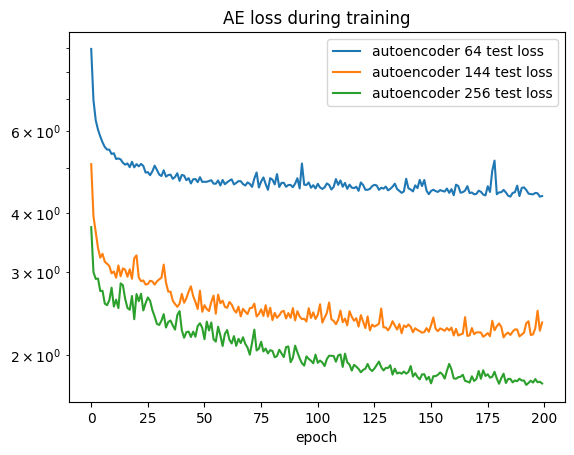

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_autoencoder_utils.py

train_autoencoder_model = False
save_autoencoder_model = False

# Note, these must all be integers that fit the following formula: (4 * n) ^ 2
# This is a requirement of the UNet that comes later
# 64 = (4 * 2) ^ 2
# 144 = (4 * 3) ^ 2
# 256 = (4 * 4) ^ 2
autoencoder_dims = [64, 144, 256]

n_epochs_autoencoder = 200
lr_autoencoder = 0.001
enc_in_dim = train_data.shape[1]
loss_infos = {}

loss_fn_autoencoder = torch.nn.MSELoss(reduction="sum")

for enc_out_dim in autoencoder_dims:
    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder.to(device)
    autoencoder_stats_path = os.path.join(file_location,
                'stats/autoencoder_count_' + str(enc_out_dim) + '.pkl')
    autoencoder_model_path = os.path.join(file_location,
                'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')

    if train_autoencoder_model:
        autoencoder.apply(weights_init)
        optimiser_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr_autoencoder, weight_decay=0.0001)

        print(f"==> Training the {enc_out_dim} autoencoder with {n_epochs_autoencoder} epochs.")
        epoch_train_loss_list = []
        epoch_test_loss_list = []
        for epoch in tqdm.tqdm(range(n_epochs_autoencoder)):
            epoch_train_loss = 0
            epoch_test_loss = 0
            autoencoder.train()
            for x in train_dataloader:
                optimiser_autoencoder.zero_grad()
                encode_and_decode = autoencoder(x)
                loss = loss_fn_autoencoder(encode_and_decode, x) / x.shape[0]

                epoch_train_loss += loss.item()
                loss.backward()

                optimiser_autoencoder.step()

            autoencoder.eval()
            with torch.no_grad():
                for x in test_dataloader:
                    encode_and_decode = autoencoder(x)
                    loss = loss_fn_autoencoder(encode_and_decode, x) / x.shape[0]
                    epoch_test_loss += loss.item()

            avg_train_loss = epoch_train_loss / len(train_dataloader)
            avg_test_loss = epoch_test_loss / len(test_dataloader)
            epoch_train_loss_list.append(avg_train_loss)
            epoch_test_loss_list.append(avg_test_loss)

        print("==> Autoencoder training completed.")

        loss_info = dict()
        loss_info['epoch_train_loss_list'] = epoch_train_loss_list
        loss_info['epoch_test_loss_list'] = epoch_test_loss_list
        if save_autoencoder_model:
            with open(autoencoder_stats_path, 'wb') as file:
                pickle.dump(loss_info, file, -1)
            torch.save({'model_state_dict': autoencoder.state_dict()}, autoencoder_model_path)

        del optimiser_autoencoder

    else:
        print("===> Loading trained models")
        loss_info = dict()
        with open(autoencoder_stats_path, 'rb') as file:
            loss_info = pickle.load(file)

    loss_infos[enc_out_dim] = loss_info

    del autoencoder
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

for enc_out_dim in autoencoder_dims:
    loss_info = loss_infos[enc_out_dim]
    epoch_train_loss_list = loss_info['epoch_train_loss_list']
    epoch_test_loss_list = loss_info['epoch_test_loss_list']
    plt.plot(epoch_test_loss_list,
             label='autoencoder ' + str(enc_out_dim) + ' test loss')

plt.xlabel('epoch')
plt.title('AE loss during training')
plt.legend()
plt.yscale("log")
plt.show()

**Instantiate and Train Score Net (UNet) with autoencoders**

===> Loading model
===> Showing stats from loaded model
===> Loading model
===> Showing stats from loaded model
===> Loading model
===> Showing stats from loaded model


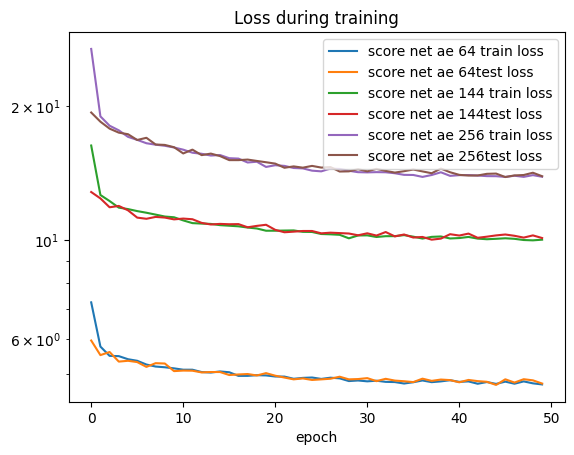

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

train_score_net = False
save_score_net_model = False

# Which autoencoders should be used to train the Score Net model
# These must all be integers that fit the following formula: (4 * n) ^ 2
# This is a requirement of the UNet architecture
# 64 = (4 * 2) ^ 2
# 144 = (4 * 3) ^ 2
# 256 = (4 * 4) ^ 2
autoencoder_dims = [64, 144, 256]

n_epochs_score_net = 50

lr_score_net = 0.001
T = 1
padding_required = False

loss_lists = {}

lr_0 = 0.5  # initial learning rate
k = 0.1    # decay rate

def lambda_func(t):
    return lr_0 * np.exp(-k * t)

for enc_out_dim in autoencoder_dims:

    # Encode training and test data:
    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py


    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder_model_path = os.path.join(file_location,
              'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')
    checkpoint = torch.load(autoencoder_model_path, map_location=device)
    autoencoder.to(device)
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    autoencoder.eval()

    train_data_encoded = autoencoder.encode(train_dataloader.dataset).detach()
    train_dataloader_encoded = DataLoader(
            dataset=train_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )
    test_data_encoded = autoencoder.encode(test_dataloader.dataset).detach()
    test_dataloader_encoded = DataLoader(
            dataset=test_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )

    sde = VPSDE()
    score_net = UNet(
        input_channels=1,
        encoded_latent_embedding_dim=enc_out_dim,
        ch=128,
        ch_mult=(1, 2, 2),
        num_res_blocks=2,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0,
    )
    score_net.apply(weights_init)
    score_net.to(device)
    loss_fn_instance_dsm = DenoisingScoreMatching(sde=sde, score_net=score_net, T=T, padding_required=padding_required)
    optimiser_score_net = torch.optim.Adam(loss_fn_instance_dsm.parameters(), lr=lr_score_net)

    score_net_stats_path = os.path.join(file_location,
                'stats/scorenet_count_ae_' + str(enc_out_dim) + '.pkl')
    score_net_model_path = os.path.join(file_location,
                'saved_models/scorenet_count_ae_' + str(enc_out_dim) + '.pt')

    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_scorenet.py

    loss_list = dict()
    if train_score_net:
        print(f"==> Training the {enc_out_dim} ae score net with {n_epochs_score_net} epochs.")

        scheduler = lr_scheduler.LambdaLR(optimiser_score_net, lr_lambda=lambda_func)

        start_time = time.time()
        train_loss_list = []
        test_loss_list = []
        for epoch in range(n_epochs_score_net):
            epoch_loss = 0
            for x in tqdm.tqdm(train_dataloader_encoded):
                optimiser_score_net.zero_grad()
                loss = loss_fn_instance_dsm.loss_fn(x).mean()
                epoch_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1)
                optimiser_score_net.step()

            avg_loss = epoch_loss / len(train_dataloader_encoded)

            train_loss_list.append(avg_loss)

            scheduler.step()

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Train Loss: {avg_loss:.5f}")

            epoch_loss = 0
            with torch.no_grad():
                for x in tqdm.tqdm(test_dataloader_encoded):
                    loss = loss_fn_instance_dsm.loss_fn(x).mean()
                    epoch_loss += loss.item()

            avg_loss = epoch_loss / len(test_dataloader_encoded)

            test_loss_list.append(avg_loss)

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Test Loss: {avg_loss:.5f}")

        print("==> Score net training completed.")
        loss_list['train_loss_list'] = train_loss_list
        loss_list['test_loss_list'] = test_loss_list
        with open(score_net_stats_path, 'wb') as file:
            pickle.dump(loss_list, file, -1)
        if save_score_net_model:
            torch.save({'model_state_dict': score_net.state_dict()}, score_net_model_path)
    else:
        print("===> Loading model")
        checkpoint = torch.load(score_net_model_path, map_location=torch.device(device))
        score_net.load_state_dict(checkpoint['model_state_dict'])
        print("===> Showing stats from loaded model")
        with open(score_net_stats_path, 'rb') as file:
            loss_list = pickle.load(file)

    loss_lists[enc_out_dim] = loss_list

    del train_data_encoded
    del train_dataloader_encoded
    del test_data_encoded
    del test_dataloader_encoded
    del loss_fn_instance_dsm
    del optimiser_score_net
    del checkpoint
    del autoencoder
    del autoencoder_model_path
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

for enc_out_dim in autoencoder_dims:
    loss_list = loss_lists[enc_out_dim]
    train_loss_list = loss_list['train_loss_list']
    test_loss_list = loss_list['test_loss_list']
    plt.plot(train_loss_list,
             label='score net ae ' + str(enc_out_dim) + ' train loss')
    plt.plot(test_loss_list,
             label='score net ae ' + str(enc_out_dim) + 'test loss')

plt.xlabel('epoch')
plt.title('Loss during training')
plt.legend()
plt.yscale("log")
plt.show()

**Instantiate and train score net (UNet) with ablations**

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

train_score_net = False
save_score_net_model = False

# Which autoencoders should be used to train the Score Net model
# These must all be integers that fit the following formula: (4 * n) ^ 2
# This is a requirement of the UNet architecture
# 64 = (4 * 2) ^ 2
# 144 = (4 * 3) ^ 2
# 256 = (4 * 4) ^ 2
autoencoder_dims = [144]

n_epochs_score_net_ablations = [12, 25, 50, 75, 100]
lr_score_net_ablations = [0.00025, 0.0005, 0.001, 0.0025, 0.005]

T = 1
padding_required = False

loss_lists = {}

lr_0 = 0.5  # initial learning rate
k = 0.1    # decay rate

def lambda_func(t):
    return lr_0 * np.exp(-k * t)

for n_epochs_score_net in n_epochs_score_net_ablations:
    lr_score_net = 0.001
    enc_out_dim = 144

    # Encode training and test data:
    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py


    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder_model_path = os.path.join(file_location,
              'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')
    checkpoint = torch.load(autoencoder_model_path, map_location=device)
    autoencoder.to(device)
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    autoencoder.eval()

    train_data_encoded = autoencoder.encode(train_dataloader.dataset).detach()
    train_dataloader_encoded = DataLoader(
            dataset=train_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )
    test_data_encoded = autoencoder.encode(test_dataloader.dataset).detach()
    test_dataloader_encoded = DataLoader(
            dataset=test_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )

    sde = VPSDE()
    score_net = UNet(
        input_channels=1,
        encoded_latent_embedding_dim=enc_out_dim,
        ch=128,
        ch_mult=(1, 2, 2),
        num_res_blocks=2,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0,
    )
    score_net.apply(weights_init)
    score_net.to(device)
    loss_fn_instance_dsm = DenoisingScoreMatching(sde=sde, score_net=score_net, T=T, padding_required=padding_required)
    optimiser_score_net = torch.optim.Adam(loss_fn_instance_dsm.parameters(), lr=lr_score_net)

    score_net_model_path = os.path.join(file_location,
                'saved_models/scorenet_count_ae_144_epoch' + str(n_epochs_score_net) + '_lr' + str(lr_score_net) + '.pt')

    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_scorenet.py

    loss_list = dict()
    if train_score_net:
        print(f"==> Training the {enc_out_dim} ae score net with {n_epochs_score_net} epochs at a {lr_score_net} learning rate.")

        scheduler = lr_scheduler.LambdaLR(optimiser_score_net, lr_lambda=lambda_func)

        start_time = time.time()
        train_loss_list = []
        test_loss_list = []
        for epoch in range(n_epochs_score_net):
            epoch_loss = 0
            for x in tqdm.tqdm(train_dataloader_encoded):
                optimiser_score_net.zero_grad()
                loss = loss_fn_instance_dsm.loss_fn(x).mean()
                epoch_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1)
                optimiser_score_net.step()

            avg_loss = epoch_loss / len(train_dataloader_encoded)

            train_loss_list.append(avg_loss)

            scheduler.step()

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Train Loss: {avg_loss:.5f}")

            epoch_loss = 0
            with torch.no_grad():
                for x in tqdm.tqdm(test_dataloader_encoded):
                    loss = loss_fn_instance_dsm.loss_fn(x).mean()
                    epoch_loss += loss.item()

            avg_loss = epoch_loss / len(test_dataloader_encoded)

            test_loss_list.append(avg_loss)

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Test Loss: {avg_loss:.5f}")

        print("==> Score net training completed.")
        loss_list['train_loss_list'] = train_loss_list
        loss_list['test_loss_list'] = test_loss_list
        if save_score_net_model:
            torch.save({'model_state_dict': score_net.state_dict()}, score_net_model_path)
    else:
        print("===> Existing model will be used when generating synthetic data.")

    loss_lists[n_epochs_score_net] = loss_list

    del train_data_encoded
    del train_dataloader_encoded
    del test_data_encoded
    del test_dataloader_encoded
    del loss_fn_instance_dsm
    del optimiser_score_net
    del checkpoint
    del autoencoder
    del autoencoder_model_path
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

for lr_score_net in lr_score_net_ablations:
    n_epochs_score_net = 50
    enc_out_dim = 144

    # Encode training and test data:
    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py


    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder_model_path = os.path.join(file_location,
              'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')
    checkpoint = torch.load(autoencoder_model_path, map_location=device)
    autoencoder.to(device)
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    autoencoder.eval()

    train_data_encoded = autoencoder.encode(train_dataloader.dataset).detach()
    train_dataloader_encoded = DataLoader(
            dataset=train_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )
    test_data_encoded = autoencoder.encode(test_dataloader.dataset).detach()
    test_dataloader_encoded = DataLoader(
            dataset=test_data_encoded,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
    )

    sde = VPSDE()
    score_net = UNet(
        input_channels=1,
        encoded_latent_embedding_dim=enc_out_dim,
        ch=128,
        ch_mult=(1, 2, 2),
        num_res_blocks=2,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0,
    )
    score_net.apply(weights_init)
    score_net.to(device)
    loss_fn_instance_dsm = DenoisingScoreMatching(sde=sde, score_net=score_net, T=T, padding_required=padding_required)
    optimiser_score_net = torch.optim.Adam(loss_fn_instance_dsm.parameters(), lr=lr_score_net)

    score_net_model_path = os.path.join(file_location,
                'saved_models/scorenet_count_ae_144_epoch' + str(n_epochs_score_net) + '_lr' + str(lr_score_net) + '.pt')

    # Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_scorenet.py

    loss_list = dict()
    if train_score_net:
        print(f"==> Training the {enc_out_dim} ae score net with {n_epochs_score_net} epochs at a {lr_score_net} learning rate.")

        scheduler = lr_scheduler.LambdaLR(optimiser_score_net, lr_lambda=lambda_func)

        start_time = time.time()
        train_loss_list = []
        test_loss_list = []
        for epoch in range(n_epochs_score_net):
            epoch_loss = 0
            for x in tqdm.tqdm(train_dataloader_encoded):
                optimiser_score_net.zero_grad()
                loss = loss_fn_instance_dsm.loss_fn(x).mean()
                epoch_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(score_net.parameters(), 1)
                optimiser_score_net.step()

            avg_loss = epoch_loss / len(train_dataloader_encoded)

            train_loss_list.append(avg_loss)

            scheduler.step()

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Train Loss: {avg_loss:.5f}")

            epoch_loss = 0
            with torch.no_grad():
                for x in tqdm.tqdm(test_dataloader_encoded):
                    loss = loss_fn_instance_dsm.loss_fn(x).mean()
                    epoch_loss += loss.item()

            avg_loss = epoch_loss / len(test_dataloader_encoded)

            test_loss_list.append(avg_loss)

            time_elapsed = time.time() - start_time
            print(f"Epoch: {epoch+1}  |  Total Time: {time_elapsed:.2f}s | Test Loss: {avg_loss:.5f}")

        print("==> Score net training completed.")
        loss_list['train_loss_list'] = train_loss_list
        loss_list['test_loss_list'] = test_loss_list
        if save_score_net_model:
            torch.save({'model_state_dict': score_net.state_dict()}, score_net_model_path)
    else:
        print("===> Existing model will be used when generating synthetic data.")

    loss_lists[lr_score_net] = loss_list

    del train_data_encoded
    del train_dataloader_encoded
    del test_data_encoded
    del test_dataloader_encoded
    del loss_fn_instance_dsm
    del optimiser_score_net
    del checkpoint
    del autoencoder
    del autoencoder_model_path
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()


===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.
===> Existing model will be used when generating synthetic data.


**Train ScoreNet With No Autoencoder**


===> Loading model
===> Showing stats from loaded model


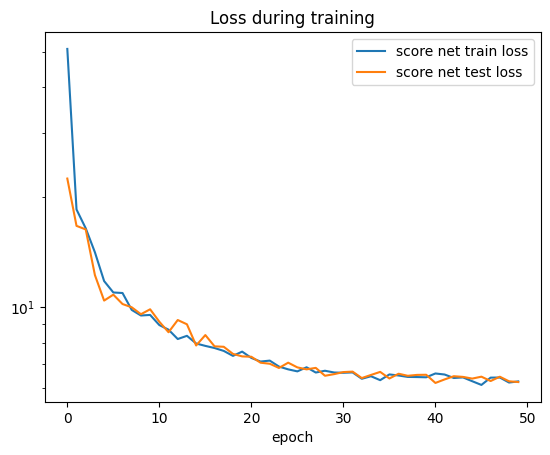

In [ ]:
train_score_net_no_ae = False
save_score_net_model_no_ae = False

# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

batch_size = 64

final_dims = 1296
padding_added_dims = final_dims - train_dataloader.dataset.shape[1]

train_data_no_ae = F.pad(input=train_dataloader.dataset, pad=(0, padding_added_dims, 0, 0), mode='constant', value=0)
train_dataloader_no_ae = DataLoader(
        dataset=train_data_no_ae,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
)
test_data_no_ae = F.pad(input=test_dataloader.dataset, pad=(0, padding_added_dims, 0, 0), mode='constant', value=0)
test_dataloader_no_ae = DataLoader(
        dataset=test_data_no_ae,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
)

lr_score_net_no_ae = 0.001
T_no_ae = 1
padding_required_no_ae = False

sde_no_ae = VPSDE()
score_net_no_ae = UNet(
    input_channels=1,
    encoded_latent_embedding_dim=train_data_no_ae.shape[1],
    ch=128,
    ch_mult=(1, 2, 2),
    num_res_blocks=2,
    attn_resolutions=(16,),
    resamp_with_conv=True,
    dropout=0,
)
score_net_no_ae.apply(weights_init)
score_net_no_ae.to(device)
loss_fn_instance_dsm_no_ae = DenoisingScoreMatching(sde=sde_no_ae, score_net=score_net_no_ae, T=T_no_ae, padding_required=padding_required_no_ae)
optimiser_score_net_no_ae = torch.optim.Adam(loss_fn_instance_dsm_no_ae.parameters(), lr=lr_score_net_no_ae)

T = 1

# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/train/train_scorenet.py

score_net_stats_path = os.path.join(file_location,
            'stats/scorenet_count_no_ae.pkl')
score_net_model_path = os.path.join(file_location,
            'saved_models/scorenet_count_no_ae.pt')

n_epochs_score_net_no_ae = 50

if train_score_net_no_ae:
    print(f"==> Training the score net with {n_epochs_score_net_no_ae} epochs.")
    lr_0_no_ae = 0.5  # initial learning rate
    k_no_ae = 0.1    # decay rate

    def lambda_func_no_ae(t_no_ae):
        return lr_0_no_ae * np.exp(-k_no_ae * t_no_ae)
    scheduler_no_ae = lr_scheduler.LambdaLR(optimiser_score_net_no_ae, lr_lambda=lambda_func_no_ae)

    start_time_no_ae = time.time()
    train_loss_list_no_ae = []
    test_loss_list_no_ae = []
    for epoch_no_ae in range(n_epochs_score_net_no_ae):
        epoch_loss_no_ae = 0
        for x_no_ae in tqdm.tqdm(train_dataloader_no_ae):
            optimiser_score_net_no_ae.zero_grad()
            loss_no_ae = loss_fn_instance_dsm_no_ae.loss_fn(x_no_ae).mean()
            epoch_loss_no_ae += loss_no_ae.item()
            loss_no_ae.backward()
            torch.nn.utils.clip_grad_norm_(score_net_no_ae.parameters(), 1)
            optimiser_score_net_no_ae.step()

        avg_loss_no_ae = epoch_loss_no_ae / len(train_dataloader_no_ae)

        train_loss_list_no_ae.append(avg_loss_no_ae)

        scheduler_no_ae.step()

        time_elapsed_no_ae = time.time() - start_time_no_ae
        print(f"Epoch: {epoch_no_ae+1}  |  Total Time: {time_elapsed_no_ae:.2f}s | Train Loss: {avg_loss_no_ae:.5f}")

        epoch_loss_no_ae = 0
        with torch.no_grad():
            for x_no_ae in tqdm.tqdm(test_dataloader_no_ae):
                loss_no_ae = loss_fn_instance_dsm_no_ae.loss_fn(x_no_ae).mean()
                epoch_loss_no_ae += loss_no_ae.item()

        avg_loss_no_ae = epoch_loss_no_ae / len(test_dataloader_no_ae)

        test_loss_list_no_ae.append(avg_loss_no_ae)

        time_elapsed_no_ae = time.time() - start_time_no_ae
        print(f"Epoch: {epoch_no_ae+1}  |  Total Time: {time_elapsed_no_ae:.2f}s | Test Loss: {avg_loss_no_ae:.5f}")

    print("==> Score net training (no autoencoder) completed.")
    plt.plot(train_loss_list_no_ae, label='score net train loss')
    plt.plot(test_loss_list_no_ae, label='score net test loss')
    plt.xlabel('epoch')
    plt.title('Loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()
    loss_list_no_ae = dict()
    loss_list_no_ae['train_loss_list'] = train_loss_list_no_ae
    loss_list_no_ae['test_loss_list'] = test_loss_list_no_ae
    with open(score_net_stats_path, 'wb') as file:
        pickle.dump(loss_list_no_ae, file, -1)
    if save_score_net_model_no_ae:
        torch.save({'model_state_dict': score_net_no_ae.state_dict()}, score_net_model_path)
else:
    print("===> Loading model")
    checkpoint_no_ae = torch.load(score_net_model_path, map_location=torch.device(device))
    score_net_no_ae.load_state_dict(checkpoint_no_ae['model_state_dict'])
    print("===> Showing stats from loaded model")
    with open(score_net_stats_path, 'rb') as file:
        loss_list_no_ae = pickle.load(file)
    train_loss_list_no_ae = loss_list_no_ae['train_loss_list']
    test_loss_list_no_ae = loss_list_no_ae['test_loss_list']
    plt.plot(train_loss_list_no_ae, label='score net train loss')
    plt.plot(test_loss_list_no_ae, label='score net test loss')
    plt.xlabel('epoch')
    plt.title('Loss during training')
    plt.legend()
    plt.yscale("log")
    plt.show()

**Generate Synthetic Data**
Once the model is trained, it can be used to generate synthetic data that can be compared to the original data to determine if it is statistically similar while still protecting the privacy of the original patients.  The generation process is described in the Score Net model section.

Note: By default, instead of generating this data instead pre-generated data is loaded and used.  You can change this by setting `generate_data = True`.

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

batch_size = 128

generate_data = False
save_generated_data = False

autoencoder_dims = [64, 144, 256]

T = 1

if generate_data:
    time_steps = 1000
    num_samples_to_generate = batch_size * 80

    print("==> Commencing reverse solve using torchsde Euler Maruyama.")

    for enc_out_dim in autoencoder_dims:
        start_time = time.time()
        print(f'==> Generating data for {enc_out_dim} ae score net')
        autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
        autoencoder_model_path = os.path.join(file_location,
                'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')
        checkpoint = torch.load(autoencoder_model_path, map_location=device)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        autoencoder.eval()
        autoencoder.to(device)

        sde = VPSDE()
        score_net = UNet(
        input_channels=1,
        encoded_latent_embedding_dim=enc_out_dim,
        ch=128,
        ch_mult=(1, 2, 2),
        num_res_blocks=2,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0,
        )
        score_net.apply(weights_init)
        score_net.to(device)

        score_net_model_path = os.path.join(file_location,
                'saved_models/scorenet_count_ae_' + str(enc_out_dim) + '.pt')

        generated_data_location = os.path.join(file_location,
                'synthetic_data/count_ae_' + str(enc_out_dim) + '.npy')

        try:
            generated_data_final = torch.Tensor(np.load(generated_data_location))
            print(f'Total records loaded: {generated_data_final.shape[0]}')
        except:
            generated_data_final = None
            print("No data loaded")

        checkpoint = torch.load(score_net_model_path, map_location=torch.device(device))
        score_net.load_state_dict(checkpoint['model_state_dict'])


        reverse_sde = ReverseSDE(sde=sde, score_net=score_net, T=T)
        torchsde_SDE = WrapperForTorchSDE(reverse_sde=reverse_sde, noise_type="diagonal", sde_type="ito")
        ts = torch.linspace(0, 1, time_steps + 1) * reverse_sde.T
        ts = ts.to(device)
        with torch.no_grad():
            assert (
                num_samples_to_generate >= batch_size
            ), "Num to generate should be greater than or equal to batch size."
            batch_iter = math.ceil(num_samples_to_generate / batch_size)
            print(f"==> Able to generate {batch_iter * batch_size} samples.")

            xs_batches = None
            for i in range(0, batch_iter):
                print(f"==> Batch {i + 1} out of {batch_iter}.")
                x_0 = torch.randn(batch_size, enc_out_dim, device=device)
                x_batch_solved = torchsde.sdeint(torchsde_SDE, x_0, ts, method="euler")
                with torch.no_grad():
                    print(
                        f"==> Decoding data generated in batch {i + 1} out of {batch_iter}."
                    )
                    x_batch_solved = torch.stack([x_batch_solved])
                    for x_encoded in x_batch_solved:
                        out = autoencoder.decode(x_encoded.to(device))
                        out = out.cpu()
                        out = out[-1].round()
                        if generated_data_final is None:
                            generated_data_final = out.detach()[:, 0:train_data.shape[1]]
                        else:
                            generated_data_final = torch.cat(
                                (generated_data_final,
                                out.detach()[:, 0:train_data.shape[1]]))
                        # del out
                        torch.cuda.empty_cache()

                if save_generated_data:
                    print("==> Saving generated data.")
                    np.save(generated_data_location, generated_data_final)
                    print(f'Generated data saved to {generated_data_location}')

                time_elapsed = time.time() - start_time
                print(f'Time elapsed: {time_elapsed} seconds')
                print(f'Total records saved: {generated_data_final.shape[0]}')
else:
    print("No data generated.  Pre-generated data will be loaded in the evaluation section.")

No data generated.  Pre-generated data will be loaded in the evaluation section.


**Generate synthetic data (Learning Rate/Epoch ablation models)**

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

batch_size = 128

generate_data = False
save_generated_data = False

T = 1
enc_in_dim = train_data.shape[1]

if generate_data:
    time_steps = 1000
    num_samples_to_generate = batch_size * 80

    print("==> Commencing reverse solve using torchsde Euler Maruyama.")

    for model_file in os.listdir(file_location + '/ablation_saved_models/'):
        enc_out_dim = 144
        start_time = time.time()
        print(f'==> Generating data for {model_file}')
        autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
        autoencoder_model_path = os.path.join(file_location,
                'saved_models/autoencoder_count_144.pt')
        checkpoint = torch.load(autoencoder_model_path, map_location=device)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        autoencoder.eval()
        autoencoder.to(device)

        sde = VPSDE()
        score_net = UNet(
        input_channels=1,
        encoded_latent_embedding_dim=enc_out_dim,
        ch=128,
        ch_mult=(1, 2, 2),
        num_res_blocks=2,
        attn_resolutions=(16,),
        resamp_with_conv=True,
        dropout=0,
        )
        score_net.apply(weights_init)
        score_net.to(device)

        score_net_model_path = os.path.join(file_location,
                'ablation_synthetic_models/' + model_file)

        generated_data_location = os.path.join(file_location,
                'ablation_synthetic_data/' + model_file.split('.')[0] + '.' + model_file.split('.')[1] + '.npy')

        try:
            generated_data_final = torch.Tensor(np.load(generated_data_location))
            print(f'Total records loaded: {generated_data_final.shape[0]}')
        except:
            generated_data_final = None
            print("No data loaded")

        checkpoint = torch.load(score_net_model_path, map_location=torch.device(device))
        score_net.load_state_dict(checkpoint['model_state_dict'])


        reverse_sde = ReverseSDE(sde=sde, score_net=score_net, T=T)
        torchsde_SDE = WrapperForTorchSDE(reverse_sde=reverse_sde, noise_type="diagonal", sde_type="ito")
        ts = torch.linspace(0, 1, time_steps + 1) * reverse_sde.T
        ts = ts.to(device)
        with torch.no_grad():
            assert (
                num_samples_to_generate >= batch_size
            ), "Num to generate should be greater than or equal to batch size."
            batch_iter = math.ceil(num_samples_to_generate / batch_size)
            print(f"==> Able to generate {batch_iter * batch_size} samples.")

            xs_batches = None
            for i in range(0, batch_iter):
                print(f"==> Batch {i + 1} out of {batch_iter}.")
                x_0 = torch.randn(batch_size, enc_out_dim, device=device)
                x_batch_solved = torchsde.sdeint(torchsde_SDE, x_0, ts, method="euler")
                with torch.no_grad():
                    print(
                        f"==> Decoding data generated in batch {i + 1} out of {batch_iter}."
                    )
                    x_batch_solved = torch.stack([x_batch_solved])
                    for x_encoded in x_batch_solved:
                        out = autoencoder.decode(x_encoded.to(device))
                        out = out.cpu()
                        out = out[-1].round()
                        if generated_data_final is None:
                            generated_data_final = out.detach()[:, 0:train_data.shape[1]]
                        else:
                            generated_data_final = torch.cat(
                                (generated_data_final,
                                out.detach()[:, 0:train_data.shape[1]]))
                        # del out
                        torch.cuda.empty_cache()

                if save_generated_data:
                    print("==> Saving generated data.")
                    np.save(generated_data_location, generated_data_final)
                    print(f'Generated data saved to {generated_data_location}')

                time_elapsed = time.time() - start_time
                print(f'Time elapsed: {time_elapsed} seconds')
                print(f'Total records saved: {generated_data_final.shape[0]}')

else:
    print("No data generated.  Pre-generated data will be loaded in the evaluation section.")

No data generated.  Pre-generated data will be loaded in the evaluation section.


**Generate Synthetic Data (No Autoencoder)**

In [ ]:
# Modified from: https://github.com/aanaseer/ScoEHR/blob/main/scoehr/main.py

batch_size_no_ae = 64

generated_data_location = os.path.join(file_location, 'synthetic_data/count_no_ae.npy')

generate_data_no_ae = False
save_generated_data_no_ae = False

T = 1

try:
    generated_data_final_no_ae = torch.Tensor(np.load(generated_data_location))
    print(f'Total records loaded: {generated_data_final_no_ae.shape[0]}')
except:
    generated_data_final_no_ae = None
    print("No data loaded")

if generate_data_no_ae:
    time_steps_no_ae = 1000
    num_samples_to_generate_no_ae = batch_size_no_ae * 164

    print("==> Commencing reverse solve using torchsde Euler Maruyama.")

    reverse_sde_no_ae = ReverseSDE(sde=sde_no_ae, score_net=score_net_no_ae, T=T_no_ae)
    torchsde_SDE_no_ae = WrapperForTorchSDE(reverse_sde=reverse_sde_no_ae, noise_type="diagonal", sde_type="ito")
    ts_no_ae = torch.linspace(0, 1, time_steps_no_ae + 1) * reverse_sde_no_ae.T
    ts_no_ae = ts_no_ae.to(device)
    with torch.no_grad():
        assert (
            num_samples_to_generate_no_ae >= batch_size_no_ae
        ), "Num to generate should be greater than or equal to batch size."
        batch_iter_no_ae = math.ceil(num_samples_to_generate_no_ae / batch_size_no_ae)
        print(f"==> Able to generate {batch_iter_no_ae * batch_size_no_ae} samples.")

        xs_batches_no_ae = None
        for i_no_ae in range(0, batch_iter_no_ae):
            print(f"==> Batch {i_no_ae + 1} out of {batch_iter_no_ae}.")
            x_0_no_ae = torch.randn(batch_size_no_ae, train_data_no_ae.shape[1], device=device)
            x_batch_solved_no_ae = torchsde.sdeint(torchsde_SDE_no_ae, x_0_no_ae, ts_no_ae, method="euler")
            with torch.no_grad():
                # print(
                #     f"==> Decoding data generated in batch {i_no_ae + 1} out of {batch_iter_no_ae}."
                # )
                x_batch_solved_no_ae = torch.stack([x_batch_solved_no_ae])
                for x_no_ae in x_batch_solved_no_ae:
                    out_no_ae = x_no_ae
                    out_no_ae = out_no_ae.cpu()
                    out_no_ae = out_no_ae[-1].round()
                    if generated_data_final_no_ae is None:
                        generated_data_final_no_ae = out_no_ae.detach()[:, 0:train_data.shape[1]]
                    else:
                        generated_data_final_no_ae = torch.cat(
                            (generated_data_final_no_ae,
                             out_no_ae.detach()[:, 0:train_data.shape[1]]))
                    # del out
                    torch.cuda.empty_cache()

            # if generated_data_final_no_ae is None:
            #     generated_data_final_no_ae = xs_batches_no_ae[:, 0:train_data.shape[1]]
            # else:
            #     generated_data_final_no_ae = torch.cat((generated_data_final_no_ae, xs_batches_no_ae[:, 0:train_data.shape[1]]))

            if save_generated_data_no_ae:
                print("==> Saving generated data.")
                np.save(generated_data_location, generated_data_final_no_ae)
                print(f'Generated data saved to {generated_data_location}')

            print(f'Total records saved: {generated_data_final_no_ae.shape[0]}')

Total records loaded: 10048


## Evaluation

### Metrics Descriptions
The original paper looked at three types of Metrics
1. Quantitative Metrics
2. Qualitative Metrics
3. Privacy Metrics

#### 1. Quantitative Metrics
**1.1 Dimensional Distribution Metric**

Assessing if marginal distributions in real data are captured by the synthetic data. ie, for a given category of data, such as age, independent of other variables, the distribution is expected.

Binary Data:

$$\boldsymbol{DWM} = \sum_{i=1}^N \vert 	\frac{1}{n_d} \sum_{j=1}^{n_d} {d}_j,_i - \hat{d}_j,_i \vert$$

Continuous Variable Data:

$$\boldsymbol{DEM} = \sum_{i=1}^N \frac{1}{n_c} \sum_{j=1}^{n_c} \vert {c}_j,_i - \hat{c}_j,_i \vert$$

Total Score:

$$\frac{DWM + DEM}{N}$$

A lower value indicates that the real and synthetic data have similar marginal relationships.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 0.0019 $\pm$ 0.0001 | 0.012 $\pm$ 0.001 |
medBGAN | 0.0016 $\pm$ 0.0001 | 0.014 $\pm$ 0.001 |
medWGAN | 0.0025 $\pm$ 0.0001 | 0.0088 $\pm$ 0.0001 |
ScoEHR | 0.0029 $\pm$ 0.0001 | 0.0037 $\pm$ 0.0001 |

**1.2 Pairwise Correlation Difference**

Assessing if the correlations in the real and synthetic datasets are similar. The Pearson Correlation Matrices are found for the real and sythetic data which are used to compute the Frobenius Norm of the difference.

$$PCD = \Vert Corr(D) - Corr(\hat D) \Vert_F$$

The closer PCD is to zero, the better the inter-dimensional relationships are caputred by the synthetic data.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 120 $\pm$ 8 | 24.1 $\pm$ 0.2 |
medBGAN | 146 $\pm$ 6 | 20.7 $\pm$ 0.5 |
medWGAN | 22.1 $\pm$ 0.4 | 15.2 $\pm$ 0.3 |
ScoEHR | 21.8 $\pm$ 0.3 | 33.6 $\pm$ 0.2 |

**1.3 Marginal and Correlation Similarity**

Assessing the similarity of the latent structure of the real and synthetic datsets. This is obtained by concatenating both datasets and using k-means clustering to determine 'G' clusters.

$$U = log(\frac{1}{G})\sum_{j=1}^G\lbrack \frac{n_j^R}{n_j} - c \rbrack ^2$$
* $G$ is the number of clusters

* ${n_j^R}$ is the number of samples from the real dataset

* ${n_j^S}$ is the number of samples from the synthetic dataset

* ${n_j}$ is the number of samples in the j-th cluster
* $c$ is $\frac{n^R}{n^R + n^S} $


A lower log-cluster score indicates more similarity between the synthetic and real data.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | -2.9 $\pm$ 0.1 | -3.7 $\pm$ 0.3 |
medBGAN | -3.2 $\pm$ 0.1 | -2.5 $\pm$ 0.2 |
medWGAN | -5.4 $\pm$ 0.2 | -6.1 $\pm$ 0.4 |
ScoEHR | -6.0 $\pm$ 0.1 | -7.8 $\pm$ 0.5 |

**1.4 Synthetic Ranking Agreement**

Assessing the utility of the synethic data for use in downstream machine learning tasks by comparing results obtained through synthetic data and results obtained when using real data. This is obtained by training and testing a machine learning model using both real and synthetic data and finding their respective AUROC.

$$SRA = \frac{1}{L(L-1)}\sum_{j=1}^L\sum_{k\ne j} \mathbb{I} ((A_j-A_k)(B_j-B_k)) > 0$$

* $L$ is the number of machine learning models
* $A$ are a set of AUROC values for models trained and tested with real data
* $B$ are  a set of AUROC values for
 models trained and tested with synthetic data
* $\mathbb{I}$ is the indicator function.

A higher SRA indicates similarity in machine learning tasks.

---
Results found in the paper:

Model | MIMIC-III Dataset | ED EHR Dataset
--- | --- | ---
medGAN | 0.83 $\pm$ 0.02 | 0.81 $\pm$ 0.02 |
medBGAN | 0.86 $\pm$ 0.03 | 0.85 $\pm$ 0.03 |
medWGAN | 0.81 $\pm$ 0.03 | 0.83 $\pm$ 0.04 |
ScoEHR | 0.87 $\pm$ 0.02 | 0.86 $\pm$ 0.03 |

Note: We chose not to recreate this metric because neither the paper nor the paper's github specified how many or which machine learning tasks were used to generate this metric.  The paper also did not explain how they generated truth-values for the synthetic data to use when calculating the AUROC metrics.

#### 2. Qualitative Metrics

**Clinician Review**

A random mixed set of real and synthetic data was inspected to evaluate realism.

---

In the paper, 100 synthetic patients and 100 real patients were combined and label as 'realistic' or 'unrealistic' by 3 board certified clinicians.

*   If a patient is considered 'unrealistic' if one clinician labeled them as such, 81% of real patients were labeled as real and 81% of synthetic patients were labeled as real
*   If a patient is considered realistic if at least one clinician labeled them as realistic, 100% of real and synthetic patients were labeled realistic
*   If a patient is considered realistic only if a majority of the 3 clinicians agreed, 93% of real patients were labeled as real and 95% of the synthetic patients were labeled as real
---
Note: We are not recreating this metric due to lack of connections with board-certified clinicians. This metric is referenced for completeness.

#### 3. Privacy

Assessing if, given a random sample of synthetic data and training data, it could be determined with likely probability that someone's data was used in the training. This is determined by calculating the Cosine Similarity between the real and synthetic data. If the probabliity is 50% or higher, the patients privacy is considered to be compromised.

### Evaluation Code
Evaluation code can be found in the following cells within this section.


**Load the data for evaluation purposes**

In [ ]:
# Load the autoencoder ablation data (this includes the primary model as well)

autoencoder_dims = [64, 144, 256, 0]

generated_data_final = {}
record_counts = []
synthetic_records = {}

for enc_out_dim in autoencoder_dims:
    if enc_out_dim == 0:
        generated_data_location = os.path.join(file_location,
          'synthetic_data/count_no_ae.npy')
    else:
        generated_data_location = os.path.join(file_location,
          'synthetic_data/count_ae_' + str(enc_out_dim) + '.npy')

    generated_data_final[enc_out_dim] = torch.Tensor(np.load(generated_data_location))
    print(f'{generated_data_final[enc_out_dim].shape[0]} records loaded for {enc_out_dim} ae')
    record_counts.append(generated_data_final[enc_out_dim].shape[0])

synthetic_data_size = min(record_counts)
real = test_data[0:synthetic_data_size].to("cpu").detach()
for enc_out_dim in autoencoder_dims:
    synthetic_records[enc_out_dim] = generated_data_final[enc_out_dim][0:synthetic_data_size].to("cpu").detach()

ablation_files = os.listdir(file_location + '/ablation_synthetic_data/')

for data_file in ablation_files:
    generated_data_location = os.path.join(file_location, 'ablation_synthetic_data', data_file)
    generated_data_final[data_file] = torch.Tensor(np.load(generated_data_location))
    print(f'{generated_data_final[data_file].shape[0]} records loaded for {data_file} ablation')
    record_counts.append(generated_data_final[data_file].shape[0])

synthetic_data_size = min(record_counts)
real = real[0:synthetic_data_size].to("cpu").detach()
for data_file in ablation_files:
    synthetic_records[data_file] = generated_data_final[data_file][0:synthetic_data_size].to("cpu").detach()

10240 records loaded for 64 ae
10240 records loaded for 144 ae
10240 records loaded for 256 ae
10048 records loaded for 0 ae
10240 records loaded for scorenet_count_ae_144_epoch25_lr0.001.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch12_lr0.001.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch50_lr0.001.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch30_lr0.005.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch75_lr0.001.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch30_lr0.00025.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch30_lr0.0005.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch30_lr0.001.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch30_lr0.0025.npy ablation
10240 records loaded for scorenet_count_ae_144_epoch100_lr0.001.npy ablation


**1.1 Dimensional Distribution Metric**

In [ ]:
DDM_results = {}
for enc_out_dim in autoencoder_dims:
    print(f'==> Showing results for {enc_out_dim} Autoencoder:')
    synthetic = synthetic_records[enc_out_dim]
    #Note: Because this is entirely count data, DWM is not needed
    DEM = torch.sum(torch.mean(torch.abs(real - synthetic), axis=0))
    DDM = DEM / len(real)
    DDM = DDM.item()
    DDM_results[enc_out_dim] = DDM
    print(f"Dimensional Distribution Metric: {round(DDM, 4)}")
    DDM_original = 0.0029
    DDM_compare = round(((DDM - DDM_original) / abs(DDM_original)) * 100,2)
    if (DDM_compare < 0):
      print(f"Recreated results have {abs(DDM_compare)}% better marginal relationships than the original.")
    elif ((DDM_compare > 0)):
      print(f"Recreated results have {DDM_compare}% worse marginal relationships than the original.")
    else:
      print("Recreated results have the same marginal relationships as the original.")

for data_file in ablation_files:
      print(f'==> Showing results for {data_file} ablation:')
      synthetic = synthetic_records[data_file]
      #Note: Because this is entirely count data, DWM is not needed
      DEM = torch.sum(torch.mean(torch.abs(real - synthetic), axis=0))
      DDM = DEM / len(real)
      DDM = DDM.item()
      DDM_results[data_file] = DDM
      print(f"Dimensional Distribution Metric: {round(DDM, 4)}")
      DDM_original = 0.0029
      DDM_compare = round(((DDM - DDM_original) / abs(DDM_original)) * 100,2)
      if (DDM_compare < 0):
        print(f"Recreated results have {abs(DDM_compare)}% better marginal relationships than the original.")
      elif ((DDM_compare > 0)):
        print(f"Recreated results have {DDM_compare}% worse marginal relationships than the original.")
      else:
        print("Recreated results have the same marginal relationships as the original.")

==> Showing results for 64 Autoencoder:
Dimensional Distribution Metric: 0.0023
Recreated results have 21.39% better marginal relationships than the original.
==> Showing results for 144 Autoencoder:
Dimensional Distribution Metric: 0.0021
Recreated results have 27.87% better marginal relationships than the original.
==> Showing results for 256 Autoencoder:
Dimensional Distribution Metric: 0.0021
Recreated results have 28.7% better marginal relationships than the original.
==> Showing results for 0 Autoencoder:
Dimensional Distribution Metric: 0.0025
Recreated results have 13.3% better marginal relationships than the original.
==> Showing results for scorenet_count_ae_144_epoch25_lr0.001.npy ablation:
Dimensional Distribution Metric: 0.0022
Recreated results have 22.66% better marginal relationships than the original.
==> Showing results for scorenet_count_ae_144_epoch12_lr0.001.npy ablation:
Dimensional Distribution Metric: 0.0021
Recreated results have 26.56% better marginal relation

**1.2 Pairwise Correlation Difference**

In [ ]:
PCD_results = {}
for enc_out_dim in autoencoder_dims:
    print(f'==> Showing results for {enc_out_dim} Autoencoder:')
    synthetic = synthetic_records[enc_out_dim]

    corr_real = torch.corrcoef(real.T)
    corr_synthetic = torch.corrcoef(synthetic.T)

    #This allows us to ignore the rows and columns with no variance (the nan values)
    corr_real[torch.isnan(corr_real)] = 0
    corr_synthetic[torch.isnan(corr_synthetic)] = 0

    PCD = torch.norm(corr_real - corr_synthetic).item()
    PCD_results[enc_out_dim] = PCD
    PCD_original = 21.8
    PCD_compare = round(((PCD - PCD_original) / abs(PCD_original)) * 100,2)
    print(f"PCD: {round(PCD, 2)}")
    if (PCD_compare < 0):
      print(f"Recreated results have {abs(PCD_compare)}% better inter-dimensional relationships than the original.")
    elif ((PCD_compare > 0)):
      print(f"Recreated results have {PCD_compare}% worse inter-dimensional relationships than the original.")
    else:
      print("Recreated results have the same marginal inter-dimensional as the original.")

for data_file in ablation_files:
      print(f'==> Showing results for {data_file} ablation:')
      synthetic = synthetic_records[data_file]

      corr_real = torch.corrcoef(real.T)
      corr_synthetic = torch.corrcoef(synthetic.T)

      #This allows us to ignore the rows and columns with no variance (the nan values)
      corr_real[torch.isnan(corr_real)] = 0
      corr_synthetic[torch.isnan(corr_synthetic)] = 0

      PCD = torch.norm(corr_real - corr_synthetic).item()
      PCD_results[data_file] = PCD
      PCD_original = 21.8
      PCD_compare = round(((PCD - PCD_original) / abs(PCD_original)) * 100,2)
      print(f"PCD: {round(PCD, 2)}")
      if (PCD_compare < 0):
        print(f"Recreated results have {abs(PCD_compare)}% better inter-dimensional relationships than the original.")
      elif ((PCD_compare > 0)):
        print(f"Recreated results have {PCD_compare}% worse inter-dimensional relationships than the original.")
      else:
        print("Recreated results have the same marginal inter-dimensional as the original.")

==> Showing results for 64 Autoencoder:
PCD: 33.64
Recreated results have 54.3% worse inter-dimensional relationships than the original.
==> Showing results for 144 Autoencoder:
PCD: 37.25
Recreated results have 70.88% worse inter-dimensional relationships than the original.
==> Showing results for 256 Autoencoder:
PCD: 36.47
Recreated results have 67.29% worse inter-dimensional relationships than the original.
==> Showing results for 0 Autoencoder:
PCD: 28.85
Recreated results have 32.32% worse inter-dimensional relationships than the original.
==> Showing results for scorenet_count_ae_144_epoch25_lr0.001.npy ablation:
PCD: 34.31
Recreated results have 57.36% worse inter-dimensional relationships than the original.
==> Showing results for scorenet_count_ae_144_epoch12_lr0.001.npy ablation:
PCD: 36.3
Recreated results have 66.52% worse inter-dimensional relationships than the original.
==> Showing results for scorenet_count_ae_144_epoch50_lr0.001.npy ablation:
PCD: 37.8
Recreated resul

**1.3 Marginal and Correlation Similarity**

Change `generate_U_results` to True to generate results - otherwise pre-generated results are used.  Note that this takes substantial time if run on a CPU-only machine.

20 was chosen for G (the number of clusters), because the ScoEHR paper did not specify how many clusters they used, however they referenced the Generation and evaluation of synthetic patient data[4] paper which used 20 clusters.

In [ ]:
generate_U_results = False

G = 20

U_results = {}

if generate_U_results:
    for enc_out_dim in autoencoder_dims:
        print(f'==> Showing results for {enc_out_dim} Autoencoder:')
        synthetic = synthetic_records[enc_out_dim]
        all = np.concatenate((real, synthetic))
        kmeans_model = sklearn.cluster.KMeans(n_clusters=G, random_state=1, init='k-means++', n_init=10).fit(all)
        kmeans_labels = kmeans_model.labels_
        real_count_per_cluster = torch.tensor(np.bincount(kmeans_labels[0:len(real)]))
        count_per_cluster = torch.tensor(np.bincount(kmeans_labels))

        c = len(real) / (len(real) + len(synthetic))
        U = float(math.log(1/G) * torch.sum(torch.pow((real_count_per_cluster/count_per_cluster) - c,2)))
        U_results[enc_out_dim] = U
        U_original = -6.0
        U_compare = round(((U - U_original) / abs(U_original)) * 100,2)
        print(f"U: {round(U, 2)}")
        if (U_compare < 0):
          print(f"Recreated results have {abs(U_compare)}% better similarity between the synthetic and real data than the original.")
        elif ((U_compare > 0)):
          print(f"Recreated results have {U_compare}% worse similarity between the synthetic and real data than the original.")
        else:
          print("Recreated results have the same similarity between the synthetic and real data as the original.")

    for data_file in ablation_files:
        print(f'==> Showing results for {data_file} Autoencoder:')
        synthetic = synthetic_records[data_file]
        all = np.concatenate((real, synthetic))
        kmeans_model = sklearn.cluster.KMeans(n_clusters=G, random_state=1, init='k-means++', n_init=10).fit(all)
        kmeans_labels = kmeans_model.labels_
        real_count_per_cluster = torch.tensor(np.bincount(kmeans_labels[0:len(real)]))
        count_per_cluster = torch.tensor(np.bincount(kmeans_labels))

        c = len(real) / (len(real) + len(synthetic))
        U = float(math.log(1/G) * torch.sum(torch.pow((real_count_per_cluster/count_per_cluster) - c,2)))
        U_results[data_file] = U
        U_original = -6.0
        U_compare = round(((U - U_original) / abs(U_original)) * 100,2)
        print(f"U: {round(U, 2)}")
        if (U_compare < 0):
          print(f"Recreated results have {abs(U_compare)}% better similarity between the synthetic and real data than the original.")
        elif ((U_compare > 0)):
          print(f"Recreated results have {U_compare}% worse similarity between the synthetic and real data than the original.")
        else:
          print("Recreated results have the same similarity between the synthetic and real data as the original.")
else:
    print("Loading pre-generated U results.")
    U_results = {64: -3.466517448425293,
      144: -5.009627819061279,
      256: -3.68813157081604,
      0: -3.2830593585968018,
      'scorenet_count_ae_144_epoch25_lr0.001.npy': -4.556731224060059,
      'scorenet_count_ae_144_epoch12_lr0.001.npy': -6.487917423248291,
      'scorenet_count_ae_144_epoch50_lr0.001.npy': -3.4607372283935547,
      'scorenet_count_ae_144_epoch30_lr0.005.npy': -29748.265625,
      'scorenet_count_ae_144_epoch75_lr0.001.npy': -3.354243040084839,
      'scorenet_count_ae_144_epoch30_lr0.00025.npy': -5.999951362609863,
      'scorenet_count_ae_144_epoch30_lr0.0005.npy': -3.6509108543395996,
      'scorenet_count_ae_144_epoch30_lr0.001.npy': -5.168017387390137,
      'scorenet_count_ae_144_epoch30_lr0.0025.npy': -5.266237258911133,
      'scorenet_count_ae_144_epoch100_lr0.001.npy': -3.966243267059326}

Loading pre-generated U results.


**3. Privacy**

In [ ]:
Privacy_results = {}

for enc_out_dim in autoencoder_dims:
    print(f'==> Showing results for {enc_out_dim} Autoencoder:')
    synthetic = synthetic_records[enc_out_dim]

    cosine_sim = torch.nn.functional.cosine_similarity(real, synthetic, dim=1)
    privacy = ((cosine_sim > 0.5).sum() / cosine_sim.shape[0]).item()
    Privacy_results[enc_out_dim] = privacy
    print(f"Privacy is NOT protected for {round(privacy * 100, 2)} % of patients")

for data_file in ablation_files:
    print(f'==> Showing results for {data_file} ablation:')
    synthetic = synthetic_records[data_file]

    cosine_sim = torch.nn.functional.cosine_similarity(real, synthetic, dim=1)
    privacy = ((cosine_sim > 0.5).sum() / cosine_sim.shape[0]).item()
    Privacy_results[data_file] = privacy
    print(f"Privacy is NOT protected for {round(privacy * 100, 2)} % of patients")

==> Showing results for 64 Autoencoder:
Privacy is NOT protected for 2.23 % of patients
==> Showing results for 144 Autoencoder:
Privacy is NOT protected for 2.79 % of patients
==> Showing results for 256 Autoencoder:
Privacy is NOT protected for 2.46 % of patients
==> Showing results for 0 Autoencoder:
Privacy is NOT protected for 1.79 % of patients
==> Showing results for scorenet_count_ae_144_epoch25_lr0.001.npy ablation:
Privacy is NOT protected for 2.53 % of patients
==> Showing results for scorenet_count_ae_144_epoch12_lr0.001.npy ablation:
Privacy is NOT protected for 1.99 % of patients
==> Showing results for scorenet_count_ae_144_epoch50_lr0.001.npy ablation:
Privacy is NOT protected for 2.59 % of patients
==> Showing results for scorenet_count_ae_144_epoch30_lr0.005.npy ablation:
Privacy is NOT protected for 0.0 % of patients
==> Showing results for scorenet_count_ae_144_epoch75_lr0.001.npy ablation:
Privacy is NOT protected for 2.68 % of patients
==> Showing results for scor

# Results

## Table of Results
Utility metrics measured with data generated using MIMIC-III dataset for all models.  Results for medGAN, medBGAN, medWGAN, and ScoEHR from ScoEHR paper[1], while our results were determined by experiment.  The best results for each metric are indicated in bold.

Model | Log-Cluster (U) | PCD | Dimensional Distribution (DDM) | Records Not Privacy Protected (%)
--- | --- | --- | --- | ---
medGAN | -2.9 | 120 | 0.0019 | N/A
medBGAN | -3.2 | 146 | **0.0016** | N/A
medWGAN | -5.4 | 22.1 | 0.0025 | N/A
ScoEHR | **-6.0** | **21.8** | 0.0029 | 0%
Team 97 ScoEHR Recreation | -5.0 | 37.3 | 0.0021 | 2.8%

## Claims Supported by Experiment Results
The code to generate the above table of results, including our experiment results, can be found in the cell titled *Code to generate the table of results*.  The Team 97 ScoEHR Recreation results are the results in the 144 model line (this is the 144-feature autoencoder which matches the autoencoder size from the paper).

## Results With Respect to the Hypothesis and Results From the Original Paper
As noted in the scope of reproducibility, two central hypotheses were tested as a part of this paper: ScoEHR produces higher-quality synthetic data than the previously-leading synthetic EHR models and United States board-certified physicians cannot differentiate between the synthetic data produced by ScoEHR and real EHR data.


1.   **Hypothesis 1:**
 - **Hypothesis:** The first hypothesis was tested by comparing ScoEHR against the three-leading synthetic EHR models (medGAN, medWGAN, and medBGAN) on four key areas: preservation of feature marginal relationships, preservation of feature correlations, preservation of full feature distributing using log-clusters, and synthetic data performance in downstream predictions of patient outcomes.
 - **Original Paper's Results:** As can be seen in the results table, the ScoEHR paper's results did demonstrate that ScoEHR produced higher-quality synthetic data than the previously-leading synthetic EHR models.  While the ScoEHR generated data didn't show top results in every category (it had the worst results for Dimensional Distribution), it did in two of the three categories of the categories (log-clustering and PCD), demonstrating that overall its results were better than that of the other three-leading synthetic EHR models.
 - **Our Recreation Results:** While we were not able to exactly match the metrics from the ScoEHR paper (our log-cluster metric was -5.0 instead of -6.0 in the original paper, our PCD was 37.3 instead of 21.8 in the original paper, and our dimensional distribution was 0.0021 instead of 0.0029 in the original paper - as a reminder lower results are better for each category), our results were still similar to the results from the paper and arguably in line with the three-leading synthetic EHR models.  For example, our log-cluster metric (-5.0) was better than two of the three comparison models (-2.9 for medGAN, -3.2 for medBGAN, and -5.4 for medWGAN), our PCD metric (37.3) was better than two of the three comparison models (120 for medGAN, 146 for medBGAN, and 22.1 for medWGAN), and our dimensional distribution metric (0.0021) was better than one of the three comparison models (0.0019 for medGAN, 0.0016 for medBGAN, and 0.0025 for medWGAN) and was better than the results in the original paper (0.0029).  Based on these results, while we were not able to exactly match the paper's results, I would argue that we were very close (and debatably reached) the original hypothesis that our synthetic generated data was better than the three-leading synthetic EHR models.

2.   **Hypothesis 2:**
 - **Hypothesis:** The second hypothesis was tested by presenting both synthetic and real EHR data to physicians and asking them to identify the “real” data. By looking at what portion of synthetic data they identified as “real” and comparing it with the portion of real data they identified as “real” the authors were able to determine that physicians were not able to tell the difference between the synthetic and real data.
 - **Original Paper's Results:** In the original paper, the authors reported three different ways to test this hypothesis.  First, they marked a patient as unrealistic if at least one clinician labeled them as unrealistic - for this test 81% of the real patients were marked as real, and 81% of the synthetic patients were marked as real, showing no noticeable difference between the real and synthetic data.  For the second test, patients were marked as real if at least one clinician labeled them as real.  In that test, 100% of both the real and synthetic patients were marked as real.  In the final test, patients were marked as real if a majority of clinicians labeled them as real - in this test 93% of the real patients were marked as real while 95% of the synthetic patients were marked as real.  These three tests demonstrated that the paper was able to match its hypothesis and the synthetic data was not distinguishable from the real data by clinicians.
 - **Our Recreation Results:** Due to a lack of access to medical clinicians we did not attempt to recreate this section; however, we still included it here for completeness.

## Experiments Beyond the Original Paper
We tested two experiments beyond the original paper:
1. Feature frequency analysis of the autoencoder
2. Feature frequency of synthetic data

**Feature frequency analysis of the autoencoder**
* Overview: The original paper didn't discuss the autoencoder in great detail or explain why they chose the hidden layer dimension they did beyond the fact that it is close to hidden dimensions chosen in previous papers.  One additional experiment we wanted to run was to understand how closely the autoencoder would be able to recreate the original dataset (so taking the test data, encoding it, decoding it, and seeing how close the decoded data was to the original results.  To do this, we created a visual representation of the frequency of features in the original dataset compared to the frequency of features in the encoded-decoded dataset.

* Results: Shown below the cell titled *Feature frequency analysis of the autoencoder*

* Discussion: As you can see, all three encoded-decoded datasets have a feature distribution that is roughly similar to the original feature distribution, getting closer to the original feature distribution as the dimensionality of the autoencoder increases.  This suggests that the autoencoders do a good job of recreating the original data, but with higher dimensional autoencoders doing a better job (as expected).

**Feature frequency of the synthetic data**

* Overview: While the original paper compared the synthetic data against the real data using a variety of metrics, one metric they didn't compare was the frequency of ICD codes in the real data vs. the synthetic data.  It's possible for the synthetic data to have similar ICD-code relationships as the real data (e.g., ICD codes appear in the same pairs), and the same relative frequency across ICD codes without the overall frequency matching the real data.  If the synthetic data is used for a test that is dependent on the raw frequency of the data, its possible to get different results if the average frequency in the synthetic data doesn't match the average frequency in the real world.  To confirm that the synthetic data and the real data have a similar frequency, an experiment was run that looked at the raw frequency (average count) across all ICD codes across all records.

* Results:
  * Frequency of real data ICD codes: 0.0132
  * Frequency of synthetic data ICD codes: 0.0083
  * Note: These results can be found in the cell titled *Code for the feature frequency analysis of synthetic data*

* Discussion: As can be seen in the results, there is a significant difference between the average ICD code frequency in the synthetic data compared to the real data, even though the results are *good* based on the metrics in the original paper.  This would suggest that more work is needed to determine what metrics are needed to determine that synthetic data and real data are similar.

## Ablation Study
We tested three ablations:
1. Synthetic data results without using an autoencoder
2. Synthetic data results with a varied UNet learning rate
3. Synthetic data results with a varied UNet epoch count

**Synthetic Data Results With Autoencoder Variations**
* Overview: This was a recreation of an ablation included in the original paper which hypothesized that the synthetic data generated using an autoencoder would be more accurate than the synthetic data generated without using an autoencoder.  In addition, we tested autoencoders with different numbers of features.  While the paper didn't fully explain their thought process around why removing the autoencoder would make results worse, we assume it is because the autoencoder would help to identify relationships between ICD codes that frequently occur together which would help improve the metrics (and take the responsibility of identifying all of the ICD code relationships off of the UNet).

* Results:

Model | Log-Cluster (U) | PCD | Dimensional Distribution (DDM)
--- | --- | --- | ---
Paper ScoEHR (144 Feature Autoencoder) | -6.0 | 21.8 | 0.0029
Team 97 ScoEHR 64 Feature Autoencoder | -3.5 | 33.6 | 0.0023
Team 97 ScoEHR 144 Feature Autoencoder | -5.0 | 37.3 | 0.0021
Team 97 ScoEHR 256 Feature Autoencoder | -3.7 | 36.5 | 0.0021
Paper ScoEHR No Autoencoder | -1.4 | 22.8 | 5
Team 97 No Autoencoder | -3.3 | 28.8 | 0.0025

Note: These results can be found in the cell titled *Code to generate the table of results*.

* Discussion: While our results aligned with the hypothesis that no autoencoder would produce worse results than using an autoencoder (two of the three metrics were better with the autoencoder than with no autoencoder), one of our results, the dimensional distribution metric was significantly different than the ablation within the paper (0.0025 for our recreation vs 5 for the paper).  Our no autoencoder result was relatively close to the results for the autoencoder model, while the paper indicated that no autoencoder was so far off from the autoencoder results that it should not be considered.  We haven't found anything that would explain these differences, and we assume that our implementation for no autoencoder was significantly different from the way the paper implemented it.  In addition to this, our results showed that the autoencoder with 144 features (as described in the paper) produced the best results.

**Synthetic Data Results With a Varied UNet Learning Rate**
* Overview: A critical hyperparameter, the learning rate, was adjusted between a range of 0.00025 and 0.005 in order to see if there are any differences in found local minimas.

* Results

Model | Log-Cluster (U) | PCD | Dimensional Distribution (DDM)
--- | --- | --- | ---
0.00025 Learning Rate | -6.0 | 35.6 | 0.0019
0.0005 Learning Rate | -3.7 | 36.9 | 0.0022
0.001 Learning Rate | -5.2 | 39.5 | 0.0021
0.0025 Learning Rate | -5.3 | 39.2 | 0.0021
0.005 Learning Rate | -29748 | 131.4 | 5.4636

Note: These results can be found in the cell titled *Code to generate the table of results*

* Discussion: As expected, the smaller, more granular, learning rate has the best performance, likely due to being more sensitive to finding local minimas. Despite this, all of the metrics for learning rates between 0.00025 and 0.0025 had comparable results. It is not until the learning rate is set to 0.005 that we see a significant degradation in the quality of the synthetic data.

**Synthetic Data Results With a Varied UNet Epoch Count**
* Overview: The number of epochs, a key metric that is not discussed or justified within the paper. Using a range of 12 to 100 epochs, we investigate  when loss seems to converge and metrics no longer improve.

* Results

Model | Log-Cluster (U) | PCD | Dimensional Distribution (DDM)
--- | --- | --- | ---
12 Epochs | -6.5 | 36.3 | 0.0021
25 Epochs | -4.6 | 34.3 | 0.0022
30 Epochs | -5.2 | 39.5 | 0.0021
50 Epochs | -3.5 | 37.8 | 0.0022
75 Epochs | -3.4 | 35.6 | 0.0022
100 Epochs | -4.0 | 38.6 | 0.0021

Note: These results can be found in the cell titled *Code to generate the table of results*

* Discussion: While the paper seemed to prefer an epoch of 20, we noticed that our results converged around 50 epochs. There are some oddities with our results, such as a Log-Cluster spike at 30 epochs before going back down, PCD oscilating through epochs, and Dimensional Distribution staying very tight.


**Code to generate the table of results**

In [ ]:
#Modified from https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook

DDM_results["Paper"] = 0.0029
PCD_results["Paper"] = 21.8
U_results["Paper"] = -6.0
Privacy_results["Paper"] = 0

DDM_results["Paper No AE"] = 5
PCD_results["Paper No AE"] = 22.8
U_results["Paper No AE"] = -1.4
Privacy_results["Paper No AE"] = 0

DDM_results["medGAN"] = 0.0019
PCD_results["medGAN"] = 120
U_results["medGAN"] = -2.9
Privacy_results["medGAN"] = 0

DDM_results["medBGAN"] = 0.0016
PCD_results["medBGAN"] = 146
U_results["medBGAN"] = -3.2
Privacy_results["medBGAN"] = 0

DDM_results["medWGAN"] = 0.0025
PCD_results["medWGAN"] = 22.1
U_results["medWGAN"] = -5.4
Privacy_results["medWGAN"] = 0

data = []
data.append(["Model", "DDM", "PCD", "U", "Privacy (%)"])

model_list = autoencoder_dims + ablation_files + ["Paper", "Paper No AE", "medGAN", "medBGAN", "medWGAN"]

for model in model_list:
    data_row = [model,
                str(round(DDM_results[model], 4)),
                str(round(PCD_results[model], 1)),
                str(round(U_results[model], 2)),
                str(round(Privacy_results[model] * 100, 2))]
    data.append(data_row)

def print_matrix(list_of_list):

    #Determine the width of each column
    col_width = [0 for i in list_of_list[0]]
    for list in list_of_list:
        for i in range(len(list)):
            col_width[i] = max(col_width[i], len(str(list[i])))

    number_width = len(str(max([len(i) for i in list_of_list])))
    cols = max(map(len, list_of_list))
    output = ""

    #Create first row
    output += "+"
    for width in col_width:
        output += "-"*(width+2)+"+"
    output += "\n"

    #Create data rows
    for i in range(len(list_of_list)):
        list = list_of_list[i]
        output += "|"
        for j in range(len(list)):
            item = str(list[j])
            output += " "
            output += item
            output += " "*(col_width[j]-len(item))
            output += " |"

        output += "\n"

        if i != len(list_of_list)-1:
            output += "+"
            for width in col_width:
                output += "-"*(width+2)+"+"
            output += "\n"

    #Create last row
    output += "+"
    for width in col_width:
        output += "-"*(width+2)+"+"
    output += "\n"

    return output

print(print_matrix(data))

+---------------------------------------------+--------+-------+-----------+-------------+
| Model                                       | DDM    | PCD   | U         | Privacy (%) |
+---------------------------------------------+--------+-------+-----------+-------------+
| 64                                          | 0.0023 | 33.6  | -3.47     | 2.23        |
+---------------------------------------------+--------+-------+-----------+-------------+
| 144                                         | 0.0021 | 37.3  | -5.01     | 2.79        |
+---------------------------------------------+--------+-------+-----------+-------------+
| 256                                         | 0.0021 | 36.5  | -3.69     | 2.46        |
+---------------------------------------------+--------+-------+-----------+-------------+
| 0                                           | 0.0025 | 28.8  | -3.28     | 1.79        |
+---------------------------------------------+--------+-------+-----------+-------------+

**Feature frequency analysis of the autoencoder**

Showing feature distribution for 64 autoendoer.

Original Test Data Mean:  tensor(0.0131)
After Autoencoder Test Data Mean  tensor(0.0117)


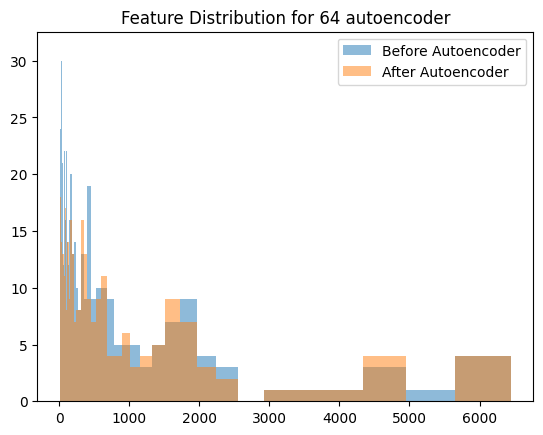


Showing feature distribution for 144 autoendoer.

Original Test Data Mean:  tensor(0.0131)
After Autoencoder Test Data Mean  tensor(0.0126)


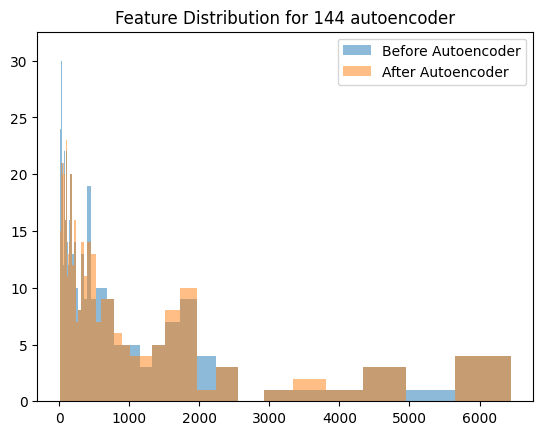


Showing feature distribution for 256 autoendoer.

Original Test Data Mean:  tensor(0.0131)
After Autoencoder Test Data Mean  tensor(0.0126)


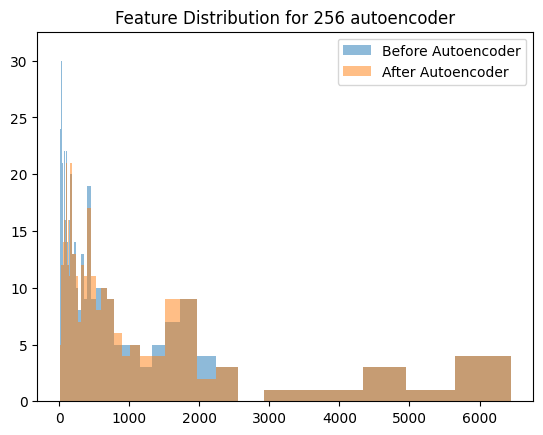

In [ ]:
for enc_out_dim in autoencoder_dims:
    if enc_out_dim == 0:
        continue
    autoencoder = Autoencoder(enc_in_dim, enc_out_dim)
    autoencoder_model_path = os.path.join(file_location,
            'saved_models/autoencoder_count_' + str(enc_out_dim) + '.pt')
    checkpoint = torch.load(autoencoder_model_path, map_location=device)
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    autoencoder.eval()
    autoencoder.to(device)

    test_data_encoded = autoencoder.encode(test_data).detach()
    test_data_decoded = autoencoder.decode(test_data_encoded).detach()

    print(f'Showing feature distribution for {enc_out_dim} autoendoer.')
    print("")

    test_data_decoded_count = test_data_decoded.round()
    print("Original Test Data Mean: ", test_data.mean())
    print("After Autoencoder Test Data Mean ", test_data_decoded_count.mean())

    test_data_np = test_data.sum(axis=0).cpu().numpy()
    test_data_decoded_np = test_data_decoded_count.sum(axis=0).cpu().numpy()

    max_count = max(test_data_np.max(), test_data_decoded_np.max())
    bins = np.logspace(1.0, np.log10(max_count), num=50)

    pyplot.title(f'Feature Distribution for {enc_out_dim} autoencoder')
    pyplot.hist(test_data_np, bins, alpha=0.5, label='Before Autoencoder')
    pyplot.hist(test_data_decoded_np, bins, alpha=0.5, label='After Autoencoder')
    pyplot.legend(loc='upper right')
    pyplot.show()

    print("")

    del autoencoder
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

**Code for the feature frequency analysis of synthetic data**


In [ ]:
for data_file in ablation_files:
    print(f'==> Showing results for {data_file} ablation:')
    print(synthetic_records[data_file].mean())
for enc_out_dim in autoencoder_dims:
    print(f'==> Showing results for {enc_out_dim} Autoencoder:')
    print(synthetic_records[enc_out_dim].mean())
print("==> Showing results for real data")
print(real.mean())

==> Showing results for scorenet_count_ae_144_epoch25_lr0.001.npy ablation:
tensor(0.0102)
==> Showing results for scorenet_count_ae_144_epoch12_lr0.001.npy ablation:
tensor(0.0087)
==> Showing results for scorenet_count_ae_144_epoch50_lr0.001.npy ablation:
tensor(0.0094)
==> Showing results for scorenet_count_ae_144_epoch30_lr0.005.npy ablation:
tensor(51.2590)
==> Showing results for scorenet_count_ae_144_epoch75_lr0.001.npy ablation:
tensor(0.0093)
==> Showing results for scorenet_count_ae_144_epoch30_lr0.00025.npy ablation:
tensor(0.0062)
==> Showing results for scorenet_count_ae_144_epoch30_lr0.0005.npy ablation:
tensor(0.0093)
==> Showing results for scorenet_count_ae_144_epoch30_lr0.001.npy ablation:
tensor(0.0088)
==> Showing results for scorenet_count_ae_144_epoch30_lr0.0025.npy ablation:
tensor(0.0088)
==> Showing results for scorenet_count_ae_144_epoch100_lr0.001.npy ablation:
tensor(0.0091)
==> Showing results for 64 Autoencoder:
tensor(0.0106)
==> Showing results for 144 A

# Discussion

## Implications of the Experimental Results

The implications of the experimental results are significant in the world of synthetically generated health data.  We were able to recreate results showing that using the ScoEHR model architecture to generate synthetic health data produced results that were at least as good as other leading synthetic generation models, if not better, based on the measured metrics.  While we don't think that these metrics show the full picture of whether synthetic data is close enough to real data to be able to be in its place (for example because the frequency of ICD codes is significantly different even if the metrics are promising), it is a big step in the right direction of synthetically generated health data.

## Whether the Original Paper Was Reproducible (and If It Wasn't, What Factors Made It Irreproducible)

We found that overall the original paper was reproducible, and even though we weren't able to reproduce the exact same measures of the metrics as the paper, we were able to generate synthetic health data using their model architecture, and our metrics were relatively similar to their metrics.  Some of the things that prevented us from exactly reproducing their model included the fact that they did not specify the exact hyperparameter values for their model, and they did not provide enough information in the paper or in the GitHub code to be confident that we are recreating their metrics in the exact same way. As mentioned later in 'What Was Hard - Understanding Metrics', due to vagueness within the original paper, the Synthetic Ranking Agreement metric was unable to be replicated. Never the less, we found it promising that our results were similar to the original paper's results.

## What Was Easy

**Understanding the Autoencoder Architecture**

The autoencoder architecture in the paper was a standard autoencoder architecture, and the code was relatively easy to follow.  Understanding and recreating this section of the paper was therefore straightforward and easy.

**Access to Code in GitHub**

Having access to the author's code in GitHub made the process of reproducing the paper significantly easier than it would have been otherwise.  Interpreting and developing both the UNet that the authors used, as well as the author's variance-preserving stochastic differential equations (VPDSE) implementation would have been extremely challenging without having their original code to work from, and a different implementation of it would likely have resulted in results that differed even further from the original paper authors' results.

## What Was Difficult

**Understanding the UNet and VPSDE Architecture and Diffusion Model**

We found it challenging to understand both the UNet and VPSDE architecture that the authors used in the paper, as well as the concept of diffusion models.  We had not previously worked with diffusion models, and needed to understand them before the chapter in the course's textbook was released, so this required substantial external research to understand.  This, paired with needing to learn about UNets and a refresher on stochastic differential equations meant that a substantial amount of independent research was needed to be able to understand the structure of the paper model's architecture.

**Computational Requirements**

Several of the models required a substantial amount of time both to train as well as to generate the synthetic data.  For example, the ablation model that did not use an autoencoder (and therefore had a higher feature dimension) required ~13 hours between training and generating one set of synthetic data using a T4 GPU; with just a CPU this time would have been significantly higher.  This was a challenge for two reasons.  First, it required us to explore cloud machine learning training locations as none of us had access to a GPU with enough RAM to run the model locally.  Second, it meant that iterating and testing different results took a substantial amount of time.

**Determining Correct Hyperparameters**

We found identifying the correct hyperparameters (e.g., batch size, number of epochs for training the autoencoder, number of epochs for training the UNet, autoencoder learning rate, UNet learning rate, etc.) to be challenging because these hyperparameters were not specified in the original paper.  Additionally, while the paper's GitHub code specified some example hyperparameters, these were specified for a data set that we did not use, and it was unclear if they used the same parameters for all data sets or if they varied for each data set.  This challenge was part of the reason that we tested different ablations for learning rates and number of epochs to identify how much varying these hyperparameters would impact the end results.

**Understanding Metrics**

We found it challenging to understand the metrics that were used to calculate the final results in the paper.  While some of the metrics were explained in a way that was clear how to implement them, in other cases insufficient detail was given to ensure that we could clearly recreate them.  For example, for the log-cluster metric the paper specified the math that was used to calculate it, but included a variable, G, for the number of k-means clusters that should be used and G was never defined.  Additionally, for the Synthetic Ranking Agreement, the paper specified that when using synthetic and real data for machine learning tasks there should be the same results, however the authors did not describe which machine learning tasks they used for the test. Additionally, since the synthetic data is unlabeled, we were unable to understand how to produce a AUROC score. These issues were compounded by the fact that non of the metrics were included in the GitHub code.

## Recommendations to the Original Authors or Others Who Work in This Area For Improving Reproducibility

**Better Documentation of Hyperparameters**

Better documentation of hyperparameters would make it significantly easier to reproduce the results from this paper.  We would encourage the original authors to specify what they used for each hyperparameter, and we would encourage others who work in this area to review our ablation results when deciding what to use for each hyperparameter.

**Better Documentation of Metrics**

Better documentation of the metrics - not just what they are but also how they are specifically implemented in these examples would make it easier to reproduce the results of this paper.  For others who work in this area, we would encourage them to review our code for how we implemented these metrics as a baseline.  Additionally, for metrics that we chose not to implement due to a lack of clarity in the paper/GitHub code, we were sometimes able to find examples of how other researchers implemented them by reviewing similar papers from the references section of the ScoEHR paper, and we'd encourage others to do the same thing.

## Additional Discussions

**Data Preprocessing using pyhealth.datasets.MIMIC3Dataset**

We successfully attempted to preprocess the data and generate the matrix file using the pyhealth.datasets.MIMIC3Dataset. Basic information from the PATIENTS and ADMISSIONS tables was retrieved, and the DIAGNOSES_ICD table was loaded explicitly using PyHealth. To utilize the pyhealth.datasets.MIMIC3Dataset, we needed to download the PATIENTS.csv file in addition to the ADMISSIONS and DIAGNOSES_ICD CSV files. The code for this process is available in the Colab notebook at the following GitHub link: [Data_Preprocessing_using_pyhealth.ipynb](https://github.com/sjoslin2/Spring-24-DLH/blob/main/additional_workbooks/Data_Preprocessing_using_pyhealth.ipynb).

**Loading Synthetic data using pyhealth SampleData set**

We attempted to load the generated synthetic data to pyHealth SampleData set. Since the generated data does not have the actual ICD9 code labels and visits information, we were only able to load all count data into a single visit for each patient. The code for this process is available in the colab notebook at the fillowing Github link: [pyhealthSampleDataset.ipynb](https://github.com/sjoslin2/Spring-24-DLH/blob/main/additional_workbooks/pyhealthSampleDataset.ipynb)

# Public GitHub Repo

**URL:** https://github.com/sjoslin2/Spring-24-DLH

# References

1.   A.A. Naseer et al, ScoEHR: Generating Synthetic Electronic Health Records
using Continuous-time Diffusion Models, Proceedings of Machine Learning Research, 2023, 219:1–22, doi: https://static1.squarespace.com/static/59d5ac1780bd5ef9c396eda6/t/64d1aa32ed57852af9c0ad60/1691462195379/ID145_Research+Paper_2023.pdf
(doi url could not be found)
2. Edward Choi, Siddharth Biswal, Bradley Malin, Jon Duke, Walter F Stewart, and Jimeng Sun. Generating multi-label discrete patient records using generative adversarial networks. In Machine learning for healthcare conference, pages 286–305. PMLR, 2017.
3. Mrinal Kanti Baowaly, Chia-Ching Lin, Chao-Lin Liu, and Kuan-Ta Chen. Synthesizing electronic health records using improved generative adversarial networks. Journal of the American Medical Informatics Association, 26(3):228–241, 2019.
4. Andre Goncalves, Priyadip Ray, Braden Soper, Jennifer Stevens, Linda Coyle, and Ana Paula Sales. Generation and evaluation of synthetic patient data. BMC medical research methodology, 20(1):1–40, 2020.
